In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from copy import deepcopy
import seaborn as sns 
import matplotlib.pyplot as plt 


%matplotlib inline

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import shap
pd.set_option('display.max_rows', 250)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



/kaggle/input/patient/dataset.csv
/kaggle/input/patient-survival/Patient Survival Detection/Data Dictionary.csv
/kaggle/input/patient-survival/Patient Survival Detection/Dataset.csv


**Project: Patient Survival Prediction**


🧾**Description:** Getting a rapid understanding of the context of a patient’s overall health has been particularly important during the COVID-19 pandemic as healthcare workers around the world struggle with hospitals overloaded by patients in critical condition. Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient from another medical provider or system. Knowledge about chronic conditions can inform clinical decisions about patient care and ultimately improve patient's survival outcomes.


🧭 **Problem Statement:** The target feature is **hospital\_death** which is a binary variable. The task is to classify this variable based on the other 84 features step-by-step by going through each day's task. The scoring metric is Accuracy/Area under ROC curve.


**A.Reading Dataset**

In [2]:
details = pd.read_csv("/kaggle/input/patient-survival/Patient Survival Detection/Data Dictionary.csv")
details.head(10)

Category     Variable Name     Unit of Measure Data Type  \
0   identifier      encounter_id                None   integer   
1   identifier       hospital_id                None   integer   
2   identifier        patient_id                None   integer   
3  demographic    hospital_death                None    binary   
4  demographic               age               Years   numeric   
5  demographic               bmi  kilograms/metres^2    string   
6  demographic  elective_surgery                None    binary   
7  demographic         ethnicity                None    string   
8  demographic            gender                None    string   
9  demographic            height         centimetres   numeric   

                                         Description    Example  
0  Unique identifier associated with a patient un...       None  
1       Unique identifier associated with a hospital       None  
2        Unique identifier associated with a patient       None  
3  Whether the patient died during this hospitali...          0  
4           The age of the patient on unit admission       None  
5  The body mass index of the person on unit admi...       21.5  
6  Whether the patient was admitted to the hospit...          0  
7  The common national or cultural tradition whic...  Caucasian  
8                 The genotypical sex of the patient          F  
9         The height of the person on unit admission        180

In [3]:
# Pandas

patientData = pd.read_csv('/kaggle/input/patient-survival/Patient Survival Detection/Dataset.csv')
## Making copies of dataset
patientData1 = deepcopy(patientData)
patientData2 = deepcopy(patientData)
patientData3 = deepcopy(patientData)

**B.EDA**

1. Checking Null values.
2. Analysis of univariate (self feature) visualizations.
3. Analysis of Multivariate visualizations.
4. Dealing with missing values.

In [4]:
# Shape of dataset 
print(f"Patient survival data has {patientData.shape[0]} records and {patientData.shape[1]} features")

Patient survival data has 91713 records and 186 features


In [5]:
patientData.describe()

encounter_id     patient_id   hospital_id  hospital_death  \
count   91713.000000   91713.000000  91713.000000    91713.000000   
mean    65606.079280   65537.131464    105.669262        0.086302   
std     37795.088538   37811.252183     62.854406        0.280811   
min         1.000000       1.000000      2.000000        0.000000   
25%     32852.000000   32830.000000     47.000000        0.000000   
50%     65665.000000   65413.000000    109.000000        0.000000   
75%     98342.000000   98298.000000    161.000000        0.000000   
max    131051.000000  131051.000000    204.000000        1.000000   

                age           bmi  elective_surgery        height  \
count  87485.000000  88284.000000      91713.000000  90379.000000   
mean      62.309516     29.185818          0.183736    169.641588   
std       16.775119      8.275142          0.387271     10.795378   
min       16.000000     14.844926          0.000000    137.200000   
25%       52.000000     23.641975          0.000000    162.500000   
50%       65.000000     27.654655          0.000000    170.100000   
75%       75.000000     32.930206          0.000000    177.800000   
max       89.000000     67.814990          1.000000    195.590000   

             icu_id  pre_icu_los_days  ...  apache_4a_hospital_death_prob  \
count  91713.000000      91713.000000  ...                   83766.000000   
mean     508.357692          0.835766  ...                       0.086787   
std      228.989661          2.487756  ...                       0.247569   
min       82.000000        -24.947222  ...                      -1.000000   
25%      369.000000          0.035417  ...                       0.020000   
50%      504.000000          0.138889  ...                       0.050000   
75%      679.000000          0.409028  ...                       0.130000   
max      927.000000        159.090972  ...                       0.990000   

       apache_4a_icu_death_prob          aids     cirrhosis  \
count              83766.000000  90998.000000  90998.000000   
mean                   0.043955      0.000857      0.015693   
std                    0.217341      0.029265      0.124284   
min                   -1.000000      0.000000      0.000000   
25%                    0.010000      0.000000      0.000000   
50%                    0.020000      0.000000      0.000000   
75%                    0.060000      0.000000      0.000000   
max                    0.970000      1.000000      1.000000   

       diabetes_mellitus  hepatic_failure  immunosuppression      leukemia  \
count       90998.000000     90998.000000       90998.000000  90998.000000   
mean            0.225192         0.012989           0.026165      0.007066   
std             0.417711         0.113229           0.159628      0.083763   
min             0.000000         0.000000           0.000000      0.000000   
25%             0.000000         0.000000           0.000000      0.000000   
50%             0.000000         0.000000           0.000000      0.000000   
75%             0.000000         0.000000           0.000000      0.000000   
max             1.000000         1.000000           1.000000      1.000000   

           lymphoma  solid_tumor_with_metastasis  
count  90998.000000                 90998.000000  
mean       0.004132                     0.020638  
std        0.064148                     0.142169  
min        0.000000                     0.000000  
25%        0.000000                     0.000000  
50%        0.000000                     0.000000  
75%        0.000000                     0.000000  
max        1.000000                     1.000000  

[8 rows x 178 columns]

In [6]:
## Information abt dataset
patientData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    encounter_id                   int64  
 1    patient_id                     int64  
 2    hospital_id                    int64  
 3    hospital_death                 int64  
 4    age                            float64
 5    bmi                            float64
 6    elective_surgery               int64  
 7    ethnicity                      object 
 8    gender                         object 
 9    height                         float64
 10   hospital_admit_source          object 
 11   icu_admit_source               object 
 12   icu_id                         int64  
 13   icu_stay_type                  object 
 14   icu_type                       object 
 15   pre_icu_los_days               float64
 16   readmission_status             int64  
 17   weight                       

* As, there are lots of features, displaying has been paused.

In [7]:
# numeric columns
print("Columns of numeric valued(int): \n")
print('-------------------------------')
print(patientData.select_dtypes(include=np.int64).columns)
print("Columns of numeric valued(float): \n")
print('-------------------------------')
print(patientData.select_dtypes(include=np.float64).columns)
print("Columns of categorical valued(object): \n")
print('-------------------------------')
print(patientData.select_dtypes(include=np.object).columns)

Columns of numeric valued(int): 

-------------------------------
Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death',
       'elective_surgery', 'icu_id', 'readmission_status',
       'apache_post_operative'],
      dtype='object')
Columns of numeric valued(float): 

-------------------------------
Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'albumin_apache',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache',
       'bilirubin_apache',
       ...
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids',
       'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis'],
      dtype='object', length=170)
Columns of categorical valued(object): 

-------------------------------
Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],

In [8]:
numeric_cols = len(patientData.select_dtypes(include=['number']).columns)
print(f"Patient Survival data has {numeric_cols}  numerical columns")
categoric_cols = patientData.select_dtypes(include=np.object).columns
print(f"Patient Survival data has {len(categoric_cols)} categorical columns")


Patient Survival data has 178  numerical columns
Patient Survival data has 8 categorical columns


In [9]:
# Summarized statistics

patientData.describe()

encounter_id     patient_id   hospital_id  hospital_death  \
count   91713.000000   91713.000000  91713.000000    91713.000000   
mean    65606.079280   65537.131464    105.669262        0.086302   
std     37795.088538   37811.252183     62.854406        0.280811   
min         1.000000       1.000000      2.000000        0.000000   
25%     32852.000000   32830.000000     47.000000        0.000000   
50%     65665.000000   65413.000000    109.000000        0.000000   
75%     98342.000000   98298.000000    161.000000        0.000000   
max    131051.000000  131051.000000    204.000000        1.000000   

                age           bmi  elective_surgery        height  \
count  87485.000000  88284.000000      91713.000000  90379.000000   
mean      62.309516     29.185818          0.183736    169.641588   
std       16.775119      8.275142          0.387271     10.795378   
min       16.000000     14.844926          0.000000    137.200000   
25%       52.000000     23.641975          0.000000    162.500000   
50%       65.000000     27.654655          0.000000    170.100000   
75%       75.000000     32.930206          0.000000    177.800000   
max       89.000000     67.814990          1.000000    195.590000   

             icu_id  pre_icu_los_days  ...  apache_4a_hospital_death_prob  \
count  91713.000000      91713.000000  ...                   83766.000000   
mean     508.357692          0.835766  ...                       0.086787   
std      228.989661          2.487756  ...                       0.247569   
min       82.000000        -24.947222  ...                      -1.000000   
25%      369.000000          0.035417  ...                       0.020000   
50%      504.000000          0.138889  ...                       0.050000   
75%      679.000000          0.409028  ...                       0.130000   
max      927.000000        159.090972  ...                       0.990000   

       apache_4a_icu_death_prob          aids     cirrhosis  \
count              83766.000000  90998.000000  90998.000000   
mean                   0.043955      0.000857      0.015693   
std                    0.217341      0.029265      0.124284   
min                   -1.000000      0.000000      0.000000   
25%                    0.010000      0.000000      0.000000   
50%                    0.020000      0.000000      0.000000   
75%                    0.060000      0.000000      0.000000   
max                    0.970000      1.000000      1.000000   

       diabetes_mellitus  hepatic_failure  immunosuppression      leukemia  \
count       90998.000000     90998.000000       90998.000000  90998.000000   
mean            0.225192         0.012989           0.026165      0.007066   
std             0.417711         0.113229           0.159628      0.083763   
min             0.000000         0.000000           0.000000      0.000000   
25%             0.000000         0.000000           0.000000      0.000000   
50%             0.000000         0.000000           0.000000      0.000000   
75%             0.000000         0.000000           0.000000      0.000000   
max             1.000000         1.000000           1.000000      1.000000   

           lymphoma  solid_tumor_with_metastasis  
count  90998.000000                 90998.000000  
mean       0.004132                     0.020638  
std        0.064148                     0.142169  
min        0.000000                     0.000000  
25%        0.000000                     0.000000  
50%        0.000000                     0.000000  
75%        0.000000                     0.000000  
max        1.000000                     1.000000  

[8 rows x 178 columns]

In [10]:
# columns

patientData.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [11]:
# Null values 
patientData.isnull().sum()>0

encounter_id                     False
patient_id                       False
hospital_id                      False
hospital_death                   False
age                               True
bmi                               True
elective_surgery                 False
ethnicity                         True
gender                            True
height                            True
hospital_admit_source             True
icu_admit_source                  True
icu_id                           False
icu_stay_type                    False
icu_type                         False
pre_icu_los_days                 False
readmission_status               False
weight                            True
albumin_apache                    True
apache_2_diagnosis                True
apache_3j_diagnosis               True
apache_post_operative            False
arf_apache                        True
bilirubin_apache                  True
bun_apache                        True
creatinine_apache        

* Lot of columns have null values

In [12]:

def nullValued(df):
    data = pd.DataFrame(columns=['Col','Count','Percent'])
    for col in df.columns:
        missingCount = df[col].isnull().sum()
        if missingCount>0:
            data=data.append({'Col':col,'Count':missingCount,'Percent':(100*missingCount)/patientData.shape[0]},ignore_index=True)

    return data.sort_values(by=['Count'],ascending=False)
    
nullValued(patientData)


Col  Count    Percent
119               h1_bilirubin_max  84619  92.265001
120               h1_bilirubin_min  84619  92.265001
138                 h1_lactate_min  84369  91.992411
137                 h1_lactate_max  84369  91.992411
117                 h1_albumin_max  83824  91.398166
118                 h1_albumin_min  83824  91.398166
162           h1_pao2fio2ratio_min  80195  87.441257
161           h1_pao2fio2ratio_max  80195  87.441257
158             h1_arterial_ph_min  76424  83.329517
157             h1_arterial_ph_max  76424  83.329517
130                    h1_hco3_min  76094  82.969699
129                    h1_hco3_max  76094  82.969699
156           h1_arterial_pco2_min  75959  82.822501
155           h1_arterial_pco2_max  75959  82.822501
145                     h1_wbc_max  75953  82.815958
146                     h1_wbc_min  75953  82.815958
159            h1_arterial_po2_max  75945  82.807236
160            h1_arterial_po2_min  75945  82.807236
124                 h1_calcium_min  75863  82.717826
123                 h1_calcium_max  75863  82.717826
139               h1_platelets_max  75673  82.510658
140               h1_platelets_min  75673  82.510658
122                     h1_bun_min  75091  81.876070
121                     h1_bun_max  75091  81.876070
126              h1_creatinine_min  74957  81.729962
125              h1_creatinine_max  74957  81.729962
61          h1_diasbp_invasive_max  74928  81.698342
62          h1_diasbp_invasive_min  74928  81.698342
79           h1_sysbp_invasive_max  74915  81.684167
80           h1_sysbp_invasive_min  74915  81.684167
70             h1_mbp_invasive_min  74844  81.606751
69             h1_mbp_invasive_max  74844  81.606751
134              h1_hematocrit_min  73420  80.054082
133              h1_hematocrit_max  73420  80.054082
131              h1_hemaglobin_max  73123  79.730245
132              h1_hemaglobin_min  73123  79.730245
143                  h1_sodium_max  72617  79.178524
144                  h1_sodium_min  72617  79.178524
142               h1_potassium_min  72102  78.616990
141               h1_potassium_max  72102  78.616990
28                       ph_apache  70868  77.271488
27                     pao2_apache  70868  77.271488
26             paco2_for_ph_apache  70868  77.271488
25                    paco2_apache  70868  77.271488
15                     fio2_apache  70868  77.271488
107                 d1_lactate_max  68396  74.576123
108                 d1_lactate_min  68396  74.576123
36          d1_diasbp_invasive_min  67984  74.126896
35          d1_diasbp_invasive_max  67984  74.126896
53           d1_sysbp_invasive_max  67959  74.099637
54           d1_sysbp_invasive_min  67959  74.099637
44             d1_mbp_invasive_min  67777  73.901192
43             d1_mbp_invasive_max  67777  73.901192
154           d1_pao2fio2ratio_min  66008  71.972349
153           d1_pao2fio2ratio_max  66008  71.972349
150             d1_arterial_ph_min  60123  65.555592
149             d1_arterial_ph_max  60123  65.555592
147           d1_arterial_pco2_max  59271  64.626607
148           d1_arterial_pco2_min  59271  64.626607
152            d1_arterial_po2_min  59262  64.616794
151            d1_arterial_po2_max  59262  64.616794
12                bilirubin_apache  58134  63.386870
135                     h1_inr_max  57941  63.176431
106                     d1_inr_min  57941  63.176431
136                     h1_inr_min  57941  63.176431
105                     d1_inr_max  57941  63.176431
8                   albumin_apache  54379  59.292576
90                d1_bilirubin_min  53673  58.522783
89                d1_bilirubin_max  53673  58.522783
128                 h1_glucose_min  52614  57.368094
127                 h1_glucose_max  52614  57.368094
88                  d1_albumin_min  49096  53.532215
87                  d1_albumin_max  49096  53.532215
32              urineoutput_apache  48998  53.425360
34                      wbc_apache  22012  24.000960
86 

* We can observe, some of features have missing value percentage of over 90%, we can directly remove the features which have missing values over 80%.

In [13]:
# Let us get the column names whose missing values count is higher.


def nullValued(df):
    dicts = {}
    res = 0
    res1 = 0
    res2 = 0
    res3 = 0
    res4 = 0
    data = pd.DataFrame(columns=['Col','Count','Percent'])
    for col in df.columns:
        missingCount = df[col].isnull().sum()
        percent = (100*missingCount)/patientData.shape[0]
        if percent>90:
            res += 1
        if percent>80:
            res1 += 1
        if percent>70:
            res2 += 1
        if percent>50:
            res3 += 1
    dicts['missing values>90%: '] = res 
    dicts['missing values>80%: '] = res1
    dicts['missing values>70%: '] = res2 
    dicts['missing values>50%: '] = res3
    for key,val in dicts.items():
        print(key,val)
    

nullValued(patientData)


missing values>90%:  6
missing values>80%:  34
missing values>70%:  55
missing values>50%:  74


* Total we have 71 columns with missing values greater than 55%
* We have 55 columns with missing values greater than 70%.
* We have 34 columns with missing values greater than 80%.
* We have 6 columns with missing values greater than 90%.

- **Let us remove the columns having missing values count greater than 50% . 74 columns will be removed.**

In [14]:
# Removing higher missing value count.

# Let us get the column names whose missing values count is higher.


def nullValuedColumn(df):
    res = []
    data = pd.DataFrame(columns=['Col','Count','Percent'])
    for col in df.columns:
        missingCount = df[col].isnull().sum()
        percent = (100*missingCount)/patientData.shape[0]
        if percent>50:
            res.append(col)
    
    return res
        
higherMissingValueColumns = nullValuedColumn(patientData)


In [15]:
for col in  higherMissingValueColumns:
    patientData.drop(col,axis=1,inplace=True)
print("Remaining columns are: ",patientData.shape[1])

Remaining columns are:  112


In [16]:
# Let us deal with these 112 columns
patientData.columns[:90]

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type',
       'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
       'arf_apache', 'bun_apache', 'creatinine_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
      

* As we can observe, only first few columns have personal details about patient. Let us try to visualize them for better understanding of activity.

In [17]:
non_healthColumns = patientData.columns[:10]
print(non_healthColumns)

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height'],
      dtype='object')


In [18]:
patientData['encounter_id'].value_counts()

66154     1
76188     1
37789     1
108084    1
33405     1
         ..
65127     1
33600     1
130065    1
81357     1
1671      1
Name: encounter_id, Length: 91713, dtype: int64

In [19]:
patientData['patient_id'].value_counts()

25312    1
14664    1
60980    1
47973    1
32805    1
        ..
48476    1
90988    1
15402    1
75350    1
53612    1
Name: patient_id, Length: 91713, dtype: int64

In [20]:
patientData['hospital_id'].value_counts()

118    4333
19     3925
188    3095
161    2792
70     2754
196    2730
176    2583
21     2470
194    2258
174    2225
100    2141
55     1909
185    1744
79     1510
18     1442
157    1402
62     1386
39     1349
112    1322
76     1312
2      1284
204    1261
138    1260
116    1081
128    1045
89     1042
133    1032
13     1029
54      978
171     944
35      942
32      902
24      897
47      894
147     877
27      839
83      820
186     799
14      792
103     765
10      740
26      736
37      734
146     729
159     716
166     710
139     673
136     645
109     641
189     611
77      611
81      580
105     563
199     546
98      542
64      529
60      522
192     516
30      515
145     492
125     474
135     460
181     459
49      450
92      448
158     438
137     422
5       414
99      412
8       388
101     381
132     369
200     367
33      323
149     311
46      310
40      308
202     307
119     303
17      293
160     284
169     280
80      274
16  

In [21]:
patientData['age'].value_counts()

67.0    2271
68.0    2173
71.0    2141
72.0    2110
66.0    2059
65.0    2051
70.0    2032
63.0    1977
73.0    1972
64.0    1956
69.0    1935
62.0    1930
75.0    1916
74.0    1901
77.0    1883
78.0    1866
76.0    1859
60.0    1858
61.0    1842
59.0    1836
79.0    1783
57.0    1782
58.0    1763
80.0    1702
81.0    1661
56.0    1651
55.0    1644
83.0    1616
54.0    1598
82.0    1590
84.0    1560
53.0    1550
52.0    1484
85.0    1418
51.0    1357
86.0    1295
50.0    1253
87.0    1204
49.0    1096
88.0    1042
48.0     983
89.0     952
47.0     921
46.0     908
45.0     856
44.0     752
43.0     727
42.0     674
41.0     671
40.0     573
36.0     558
35.0     551
34.0     544
38.0     535
39.0     526
37.0     509
33.0     496
30.0     477
32.0     449
26.0     432
31.0     431
28.0     425
29.0     421
25.0     415
27.0     410
24.0     401
23.0     400
22.0     389
21.0     372
19.0     343
20.0     338
18.0     259
17.0     126
16.0      44
Name: age, dtype: int64

In [22]:
patientData['bmi'].value_counts()

14.844926    443
67.814990    422
24.017768     87
24.208110     86
27.359332     82
            ... 
61.796764      1
23.241435      1
26.130528      1
24.463976      1
47.179671      1
Name: bmi, Length: 34888, dtype: int64

In [23]:
patientData['elective_surgery'].value_counts()

0    74862
1    16851
Name: elective_surgery, dtype: int64

In [24]:
patientData['ethnicity'].value_counts()

Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64

In [25]:
patientData['gender'].value_counts()

M    49469
F    42219
Name: gender, dtype: int64

In [26]:
patientData['height'].value_counts()

167.6    5362
177.8    5289
160.0    5238
172.7    4834
165.1    4772
         ... 
173.6       1
176.9       1
169.3       1
183.6       1
186.2       1
Name: height, Length: 401, dtype: int64

In [27]:
patientData.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=112)

In [28]:
patientData = patientData[patientData[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
patientData

encounter_id  patient_id  hospital_id  hospital_death   age        bmi  \
0             66154       25312          118               0  68.0  22.730000   
1            114252       59342           81               0  77.0  27.420000   
2            119783       50777          118               0  25.0  31.950000   
3             79267       46918          118               0  81.0  22.640000   
5             33181       74489           83               0  67.0  27.560000   
...             ...         ...          ...             ...   ...        ...   
91708         91592       78108           30               0  75.0  23.060250   
91709         66119       13486          121               0  56.0  47.179671   
91710          8981       58179          195               0  48.0  27.236914   
91711         33776      120598           66               0   NaN  23.297481   
91712          1671       53612          104               0  82.0  22.031250   

       elective_surgery  ethnicity gender  height  ... aids cirrhosis  \
0                     0  Caucasian      M   180.3  ...  0.0       0.0   
1                     0  Caucasian      F   160.0  ...  0.0       0.0   
2                     0  Caucasian      F   172.7  ...  0.0       0.0   
3                     1  Caucasian      F   165.1  ...  0.0       0.0   
5                     0  Caucasian      M   190.5  ...  0.0       0.0   
...                 ...        ...    ...     ...  ...  ...       ...   
91708                 0  Caucasian      M   177.8  ...  0.0       0.0   
91709                 0  Caucasian      F   183.0  ...  0.0       0.0   
91710                 0  Caucasian      M   170.2  ...  0.0       0.0   
91711                 0  Caucasian      F   154.9  ...  0.0       0.0   
91712                 1  Caucasian      F   160.0  ...  0.0       0.0   

       diabetes_mellitus hepatic_failure immunosuppression  leukemia  \
0                    1.0             0.0               0.0       0.0   
1                    1.0             0.0               0.0       0.0   
2                    0.0             0.0               0.0       0.0   
3                    0.0             0.0               0.0       0.0   
5                    1.0             0.0               0.0       0.0   
...                  ...             ...               ...       ...   
91708                1.0             0.0               0.0       0.0   
91709                0.0             0.0               0.0       0.0   
91710                1.0             0.0               0.0       0.0   
91711                0.0             0.0               0.0       0.0   
91712                0.0             0.0               0.0       0.0   

       lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0           0.0                          0.0                Sepsis   
1           0.0                          0.0           Respiratory   
2           0.0                          0.0             Metabolic   
3           0.0                          0.0        Cardiovascular   
5           0.0                          0.0          Neurological   
...         ...                          ...                   ...   
91708       0.0                          1.0                Sepsis   
91709       0.0                          0.0                Sepsis   
91710       0.0                          0.0             Metabolic   
91711       0.0                          0.0           Respiratory   
91712       0.0                          0.0      Gastrointestinal   

       apache_2_bodysystem  
0           Cardiovascular  
1              Respiratory  
2                Metabolic  
3           Cardiovascular  
5               Neurologic  
...                    ...  
91708       Cardiovascular  
91709       Cardiovascular  
91710            Metabolic  
91711          Respiratory  
91712     Gastrointestinal  

[88284 rows x 112 columns]

**As per above value counts information**:
* 'encounter_id', 'patient_id', 'hospital_id', can be dropped as they are ids just constants
* 'encounter_id','patient_id','bmi' have lots of values, we can neglect it for visualizations.
* We can drop id contained columns as each of record has unique id, it will have count of number of records. so lets drop those id's contained columns.
* We have 147 hospitals.
* we have patients of 74 different ages.
* Two types of elective_surgeries are being performed.
* 6 types of races.
* Only Male and Female gendered patient are admitted.
* 401 different heighted patients are admitted.

In [29]:
print("Before removal: ",patientData.shape)
patientData.drop(['encounter_id','patient_id','hospital_id'],axis=1,inplace=True)
print("After removal: ",patientData.shape)

Before removal:  (88284, 112)
After removal:  (88284, 109)


***UniVariate Analysis***

* Value counts of features.

In [30]:
visualizationColumns = ['elective_surgery','ethnicity','gender']

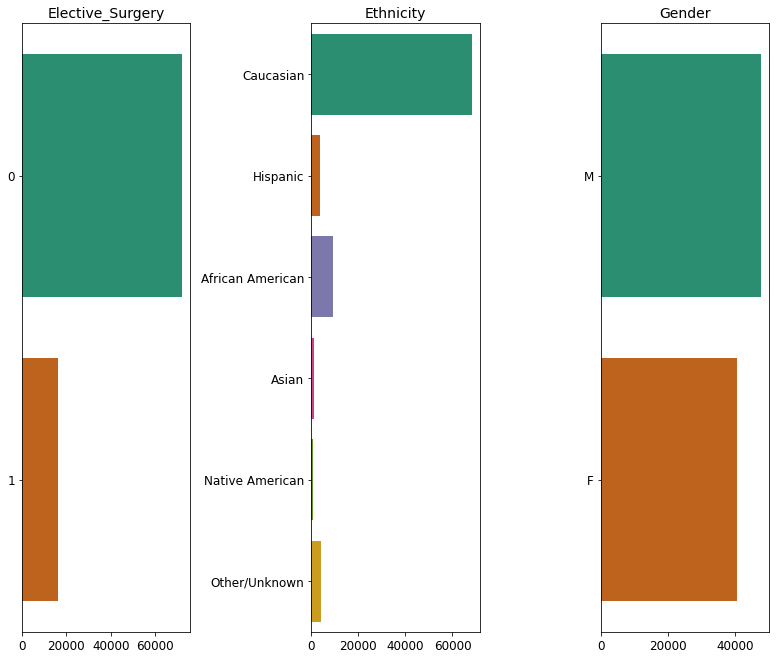

In [31]:
plt.figure(figsize=(35,80))
number = 1 
for col in visualizationColumns:
    if number<=len(visualizationColumns):

        ax1 = plt.subplot(9,9,number)
        sns.countplot(data=patientData,y=col,palette='Dark2')
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    number += 1 
plt.tight_layout()

* Almost one type of elective_surgery is preferred.
* Most patients belong to Caucasian race.
* Patients have slightly equal distribution of genders.
  - Male patients cover 55-60% of patients.
  - Female covers rest of them,

In [32]:
fig = px.histogram(patientData[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", 
                   hover_data=patientData[['age','gender','hospital_death','bmi']].columns)
fig.show()

<AxesSubplot:xlabel='count', ylabel='hospital_death'>

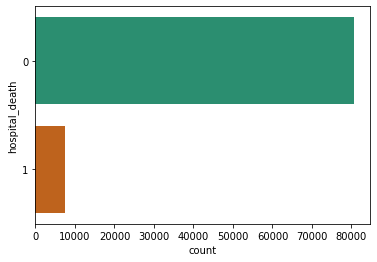

In [33]:
## Target Variable
sns.countplot(data=patientData,y='hospital_death',palette='Dark2')       

* Hospital Deaths are majorly of 0.

In [34]:
ageOfFemale_deaths = patientData[patientData['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
ageOfMale_deaths = patientData[patientData['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()

In [35]:
## Male deaths
print(ageOfMale_deaths)

     age  hospital_death
0   16.0        0.000000
1   17.0        0.051724
2   18.0        0.039683
3   19.0        0.042424
4   20.0        0.029586
5   21.0        0.050505
6   22.0        0.061856
7   23.0        0.025907
8   24.0        0.032787
9   25.0        0.015789
10  26.0        0.045455
11  27.0        0.030151
12  28.0        0.013889
13  29.0        0.036842
14  30.0        0.019763
15  31.0        0.023697
16  32.0        0.026432
17  33.0        0.067227
18  34.0        0.070513
19  35.0        0.035211
20  36.0        0.049822
21  37.0        0.044355
22  38.0        0.041667
23  39.0        0.044218
24  40.0        0.024306
25  41.0        0.041916
26  42.0        0.038012
27  43.0        0.040100
28  44.0        0.036496
29  45.0        0.033403
30  46.0        0.049180
31  47.0        0.059642
32  48.0        0.051625
33  49.0        0.051325
34  50.0        0.052933
35  51.0        0.051560
36  52.0        0.059925
37  53.0        0.055687
38  54.0        0.068309


#### For Male:

* We can notice that people with elder age, have higher death rate as it is a general case.
* Male with less than 30 years of age has lower death rate as it can noted as stronger immunity of the specific age & ability to uphold and recover from diseases.

In [36]:
print(ageOfFemale_deaths)

     age  hospital_death
0   16.0        0.041667
1   17.0        0.015873
2   18.0        0.008772
3   19.0        0.006173
4   20.0        0.006250
5   21.0        0.006173
6   22.0        0.022599
7   23.0        0.037634
8   24.0        0.030612
9   25.0        0.028986
10  26.0        0.020942
11  27.0        0.026455
12  28.0        0.026178
13  29.0        0.027650
14  30.0        0.028846
15  31.0        0.050251
16  32.0        0.018957
17  33.0        0.050633
18  34.0        0.028037
19  35.0        0.049383
20  36.0        0.023438
21  37.0        0.024691
22  38.0        0.036585
23  39.0        0.052381
24  40.0        0.042969
25  41.0        0.041401
26  42.0        0.036913
27  43.0        0.043771
28  44.0        0.055921
29  45.0        0.061947
30  46.0        0.042328
31  47.0        0.044503
32  48.0        0.053991
33  49.0        0.057778
34  50.0        0.045726
35  51.0        0.036021
36  52.0        0.075080
37  53.0        0.072981
38  54.0        0.062310


####  For Female:

* Females marks the death at an younger age of 16 too, and their deaths start highly at age of 64, whereas for men it is around at an age of 70.
* Females have high death rate, after an age of 70.

In [37]:
from plotly.subplots import make_subplots
fig = make_subplots()
fig.add_trace(go.Scatter(x=ageOfMale_deaths['age'],y=ageOfMale_deaths['hospital_death'],name='Male Patients'))
fig.add_trace(go.Scatter(x=ageOfFemale_deaths['age'],y=ageOfFemale_deaths['hospital_death'],name='Female Patients'))
fig.update_layout(title_text="<b>Average hospital death probability<b>")
fig.update_xaxes(title_text="<b>Patient Age<b>")
fig.update_yaxes(title_text="<b>Avg Hospital death<b>")
fig.show()


In [38]:
patientData.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88284 entries, 0 to 91712
Data columns (total 109 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    hospital_death                 88284 non-null  int64  
 1    age                            84229 non-null  float64
 2    bmi                            88284 non-null  float64
 3    elective_surgery               88284 non-null  int64  
 4    ethnicity                      87073 non-null  object 
 5    gender                         88266 non-null  object 
 6    height                         88284 non-null  float64
 7    hospital_admit_source          67368 non-null  object 
 8    icu_admit_source               88191 non-null  object 
 9    icu_id                         88284 non-null  int64  
 10   icu_stay_type                  88284 non-null  object 
 11   icu_type                       88284 non-null  object 
 12   pre_icu_los_days              

In [39]:
# As icu id's are just things, they really dont contirbute much.
patientData.drop(['icu_id'],axis=1,inplace=True)
patientData.drop(['readmission_status'],axis=1,inplace=True)

In [40]:
patientData.shape

(88284, 107)

In [41]:
# Let us consider some known column terms by looking at above information.
columns = ['hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','aids','leukemia','immunosuppression']

In [42]:
print(columns)

['hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'aids', 'leukemia', 'immunosuppression']


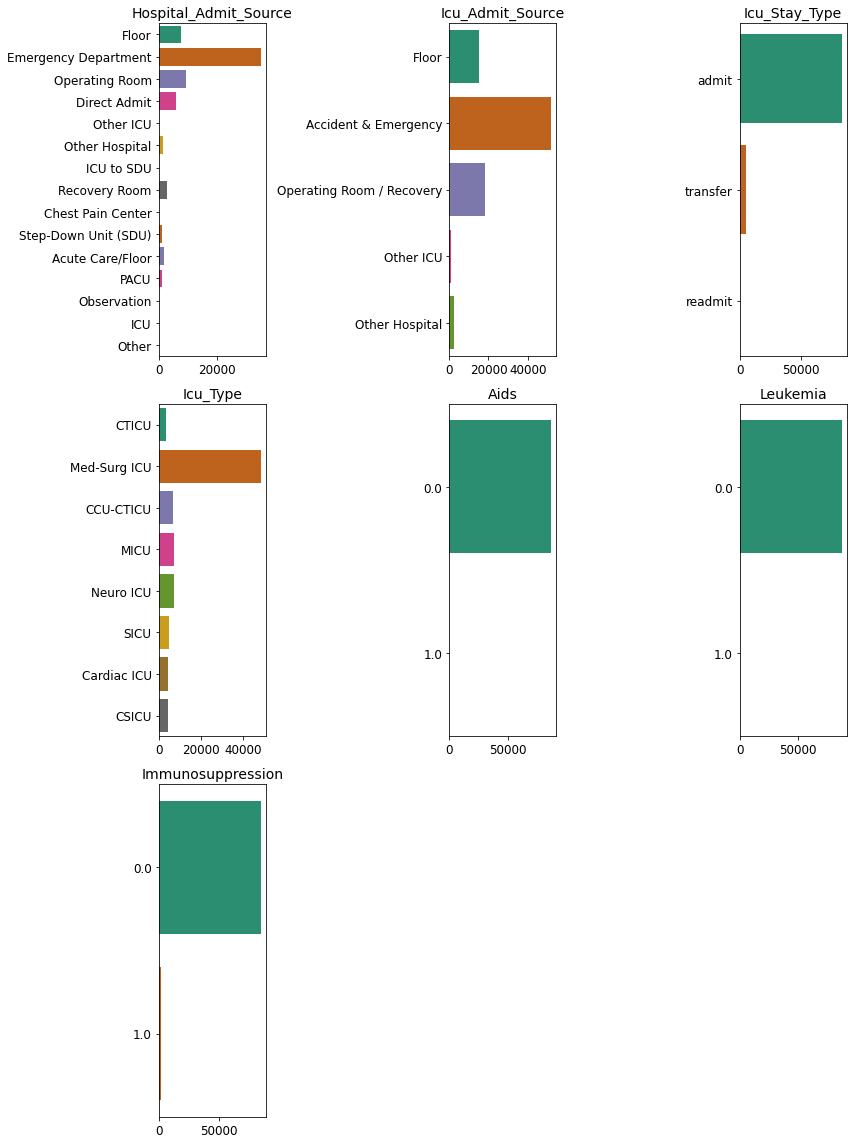

In [43]:
plt.figure(figsize=(12,16))
number = 1 
for col in columns:
    if number<=len(columns):
        ax1 = plt.subplot(3,3,number)
        sns.countplot(data=patientData,y=col,palette='Dark2')
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    number += 1 
plt.tight_layout()

**As per above visualizations:**

* Most of patients are in emergency department.
* Around 50%, half of patients are admitted in Accident&Emergency wards.
* Around 70% of patients are kept in ICU.
* Around 55% of patients have under gone Medical surgery.
* No patient have Aids.
* No patient have lukemia.
* Rarely patients of 1% of total records have immunosuppression.
* All are in readmission_status.

***MultiVariate Analysis***

* Comparison with target variable.

#### Impacts of BMI & Weights over patients

In [44]:
weight_data = patientData[['weight','bmi','hospital_death']]
weight_data['weight'] = weight_data['weight'].round(0)
weight_data['bmi'] = weight_data['bmi'].round(0)
weight_death = weight_data[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death = weight_data[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig = make_subplots(rows=1,cols=2,shared_yaxes=True)
fig.add_trace(go.Scatter(x=weight_death['weight'],y=weight_death['hospital_death'],name='Weight'))
fig.add_trace(go.Scatter(x=bmi_death['bmi'],y=bmi_death['hospital_death'],name='BMI'))
fig.update_layout(title_text="<b>Impact of BMI & Weights over patients<b>")
fig.show()

In [45]:
ICU_type = patientData[['icu_type','age','hospital_death']]
ICU_type['icu'] = ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU','Cardiac ICU':'CCT-CTICU','CTICU':'CCT-CTICU','CSICU':'SICU'})

ICU_data = ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_data['count'] = ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_data,x='age',y='hospital_death',size='count',color='icu_type',hover_name='icu_type',log_x=False,size_max=60,)
fig.update_layout(title_text="<b>Survival Rate at different types of ICU<b>")
fig.update_yaxes(title_text="<b>Avg hospital_death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

In [46]:
print("After a bit of cleaning: ")
print("------------------------")
numeric_cols = patientData.select_dtypes(include=['number']).columns
print(f"Patient Survival data has {len(numeric_cols)}  numerical columns")
categoric_cols = patientData.select_dtypes(include=np.object).columns
print(f"Patient Survival data has {len(categoric_cols)} categorical columns")


After a bit of cleaning: 
------------------------
Patient Survival data has 99  numerical columns
Patient Survival data has 8 categorical columns


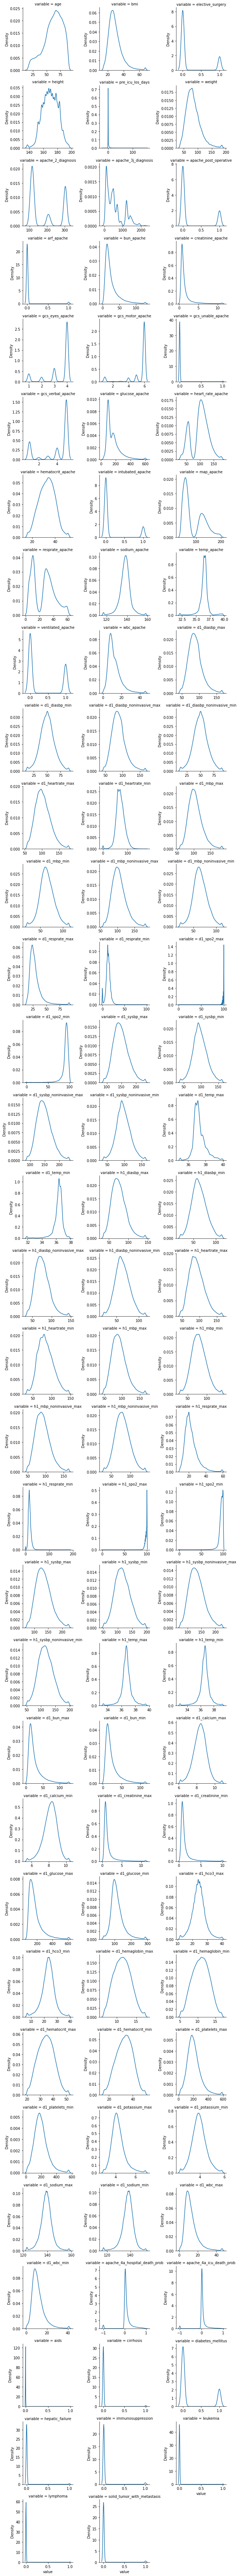

In [47]:
# Density Distribution of numerical columns
unpivot = pd.melt(patientData,patientData.describe().columns[0],patientData.describe().columns[1:])
graph = sns.FacetGrid(unpivot,col='variable',col_wrap=3,sharex=False,sharey=False)
graph.map(sns.kdeplot,"value")
plt.show()

### Observations:

From visualizations,

* Higher the age, higher the probability of deaths.
* Lower the BMI, higher the probability of deaths.
* Lower the WBC apache, higher the severity of illness.

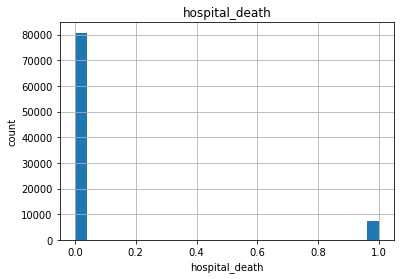

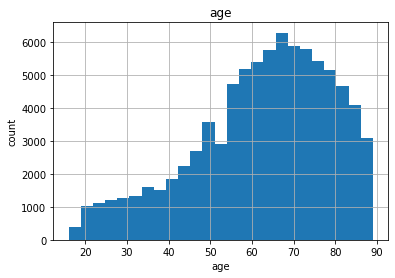

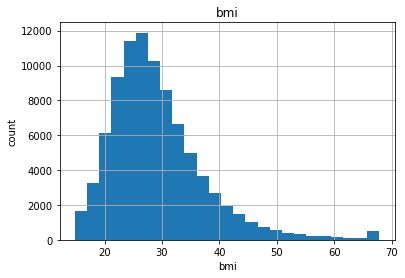

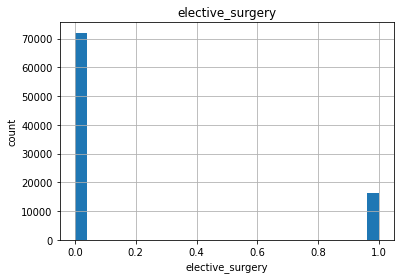

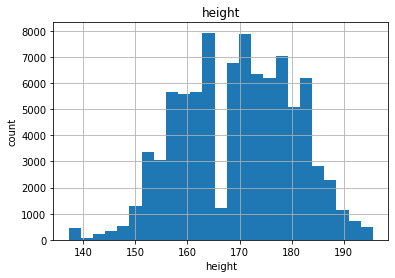

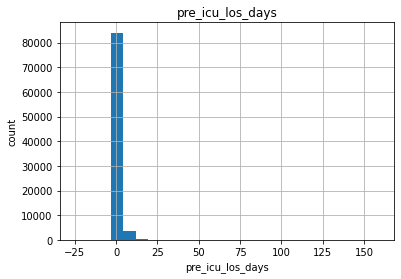

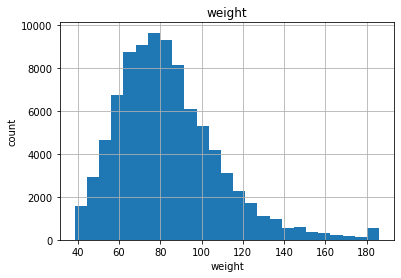

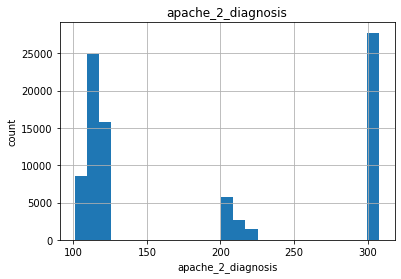

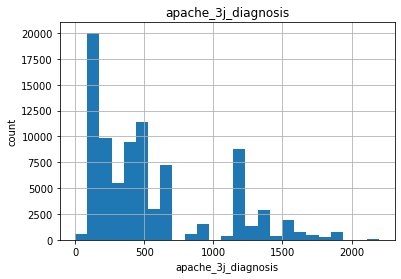

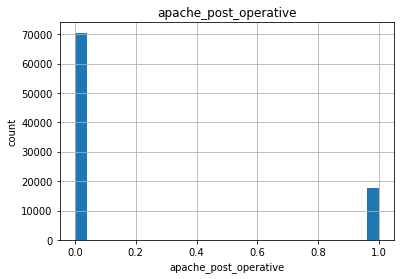

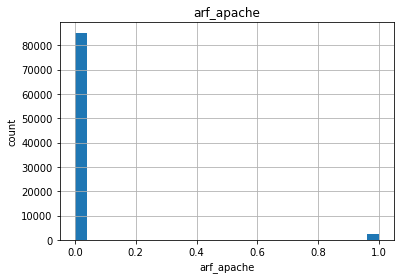

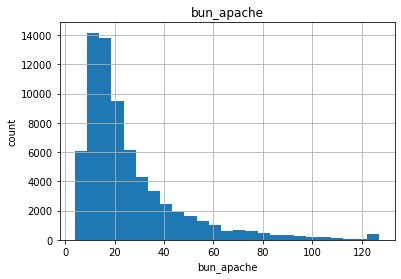

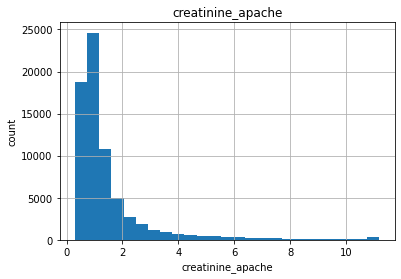

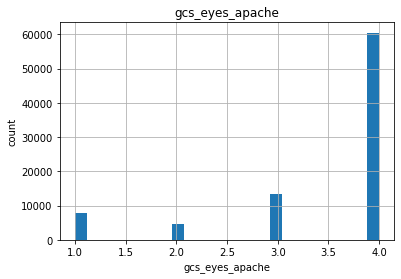

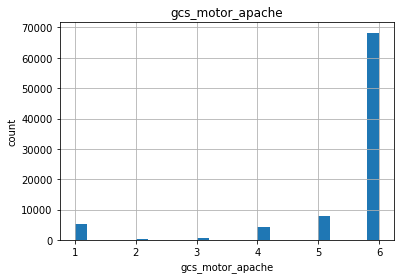

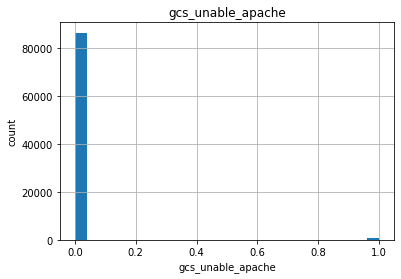

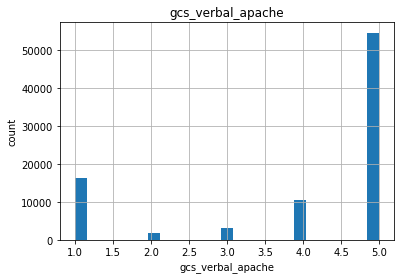

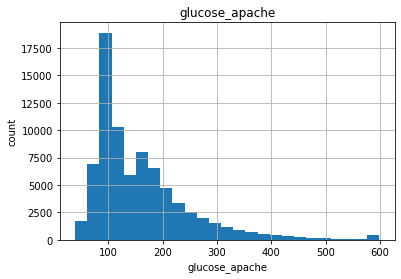

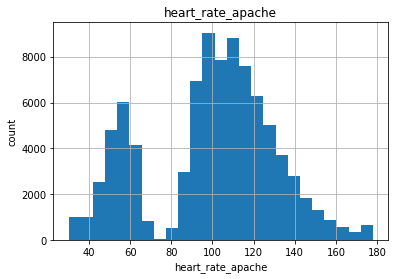

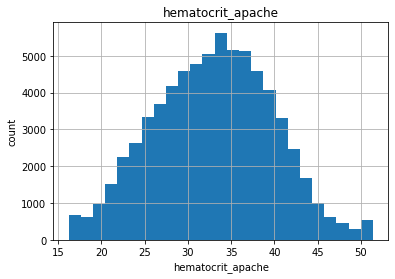

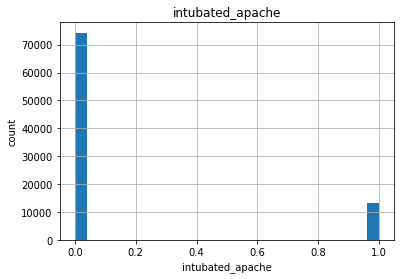

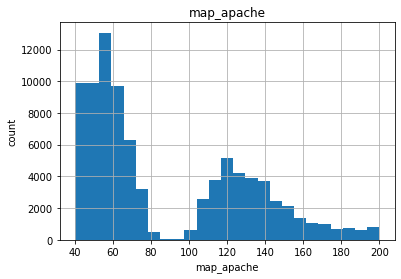

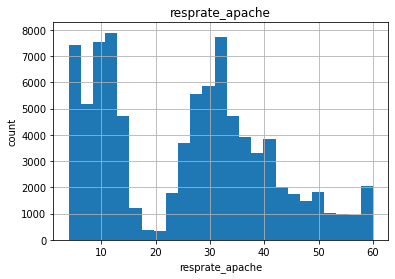

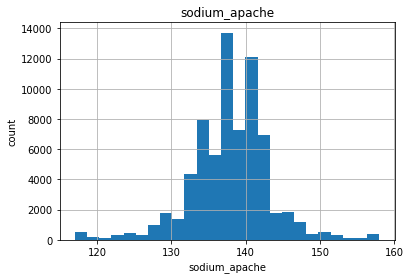

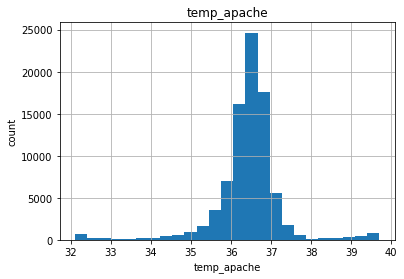

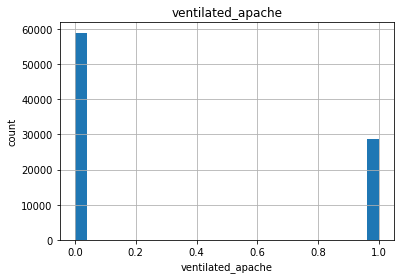

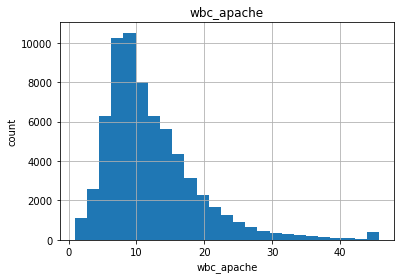

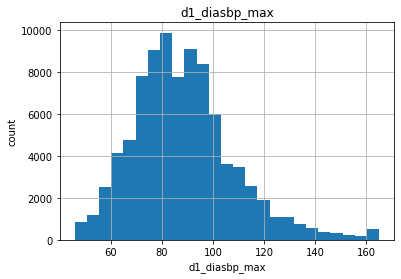

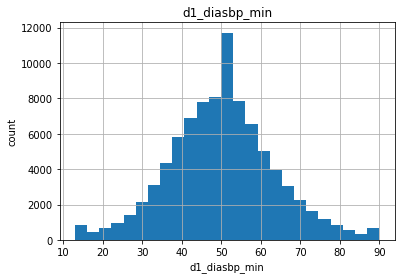

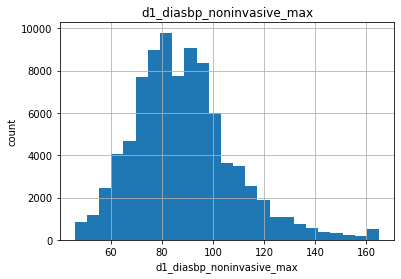

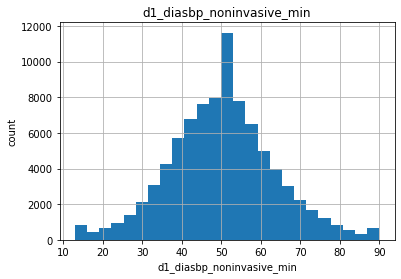

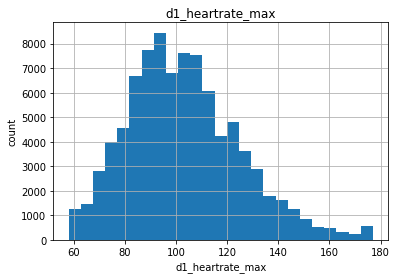

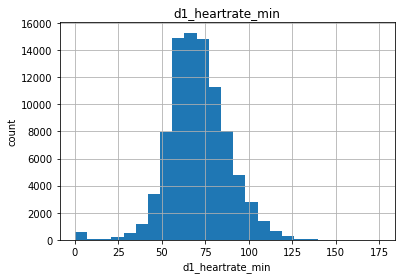

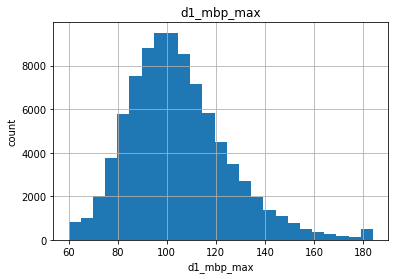

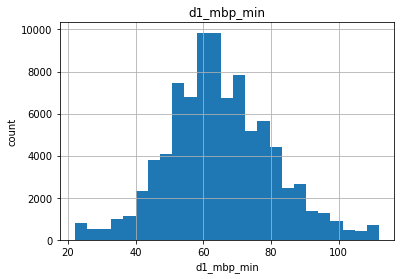

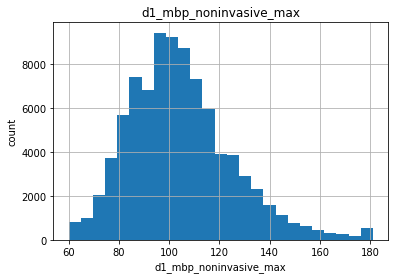

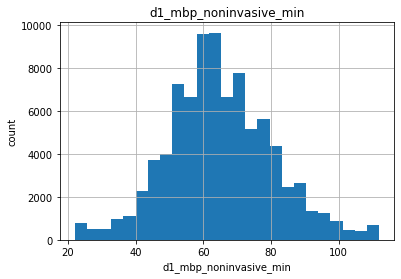

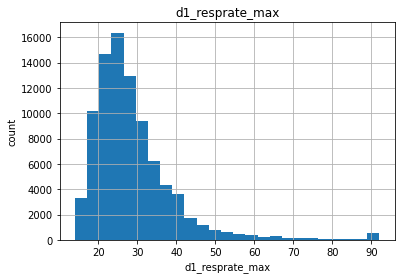

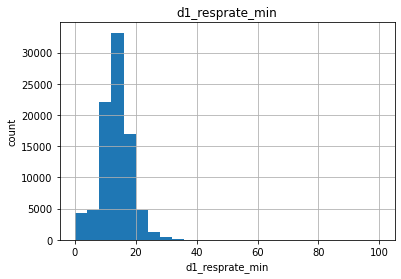

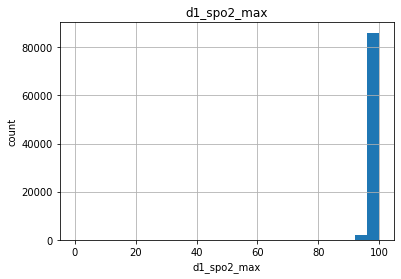

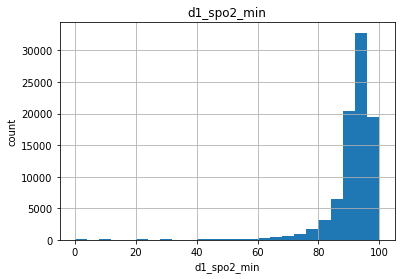

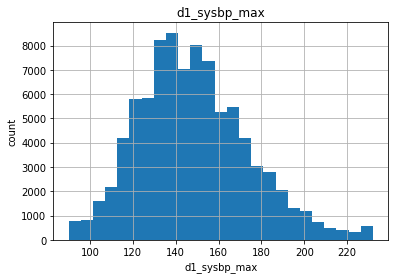

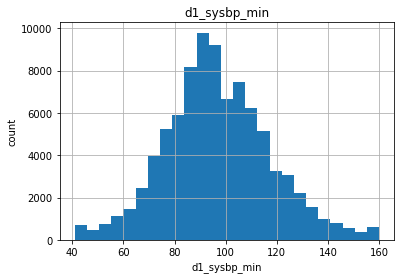

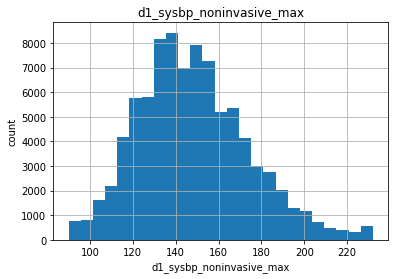

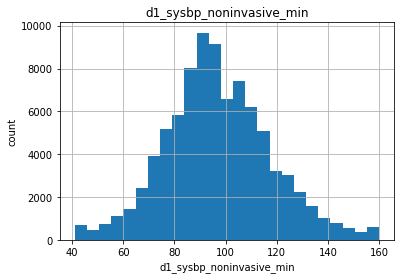

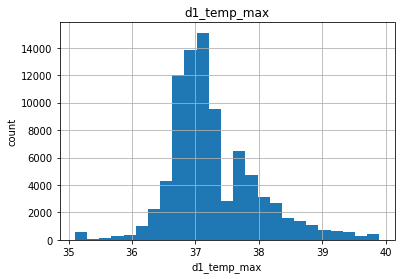

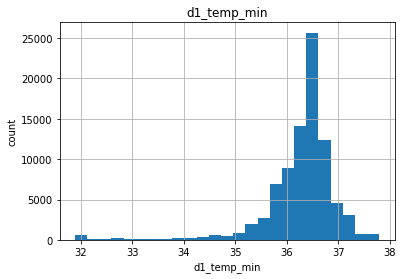

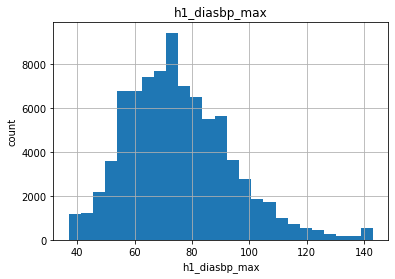

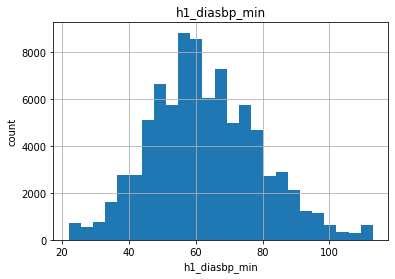

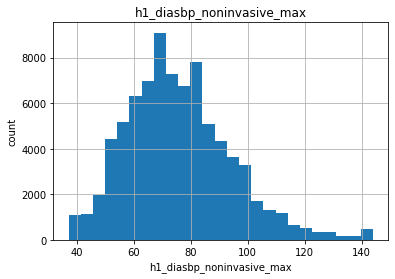

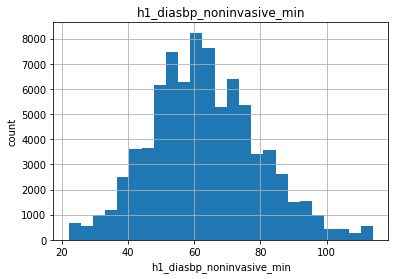

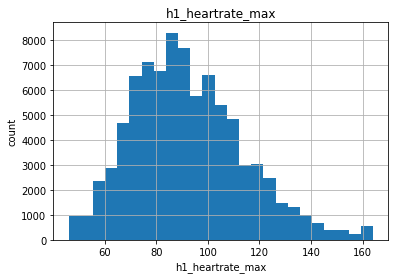

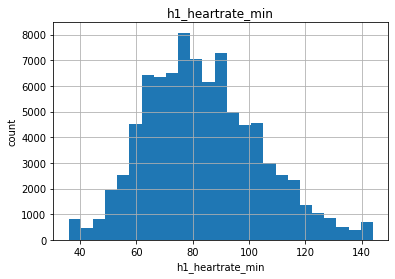

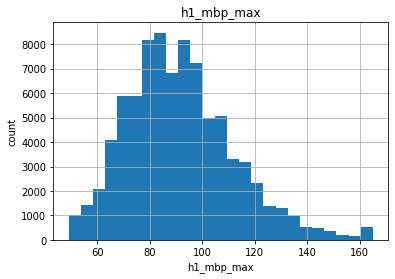

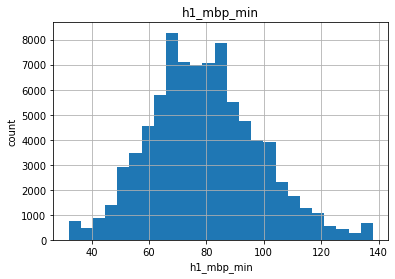

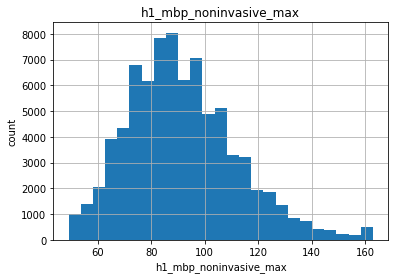

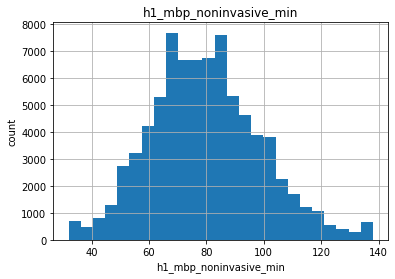

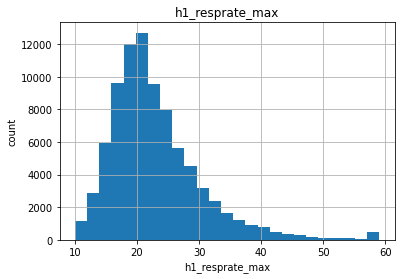

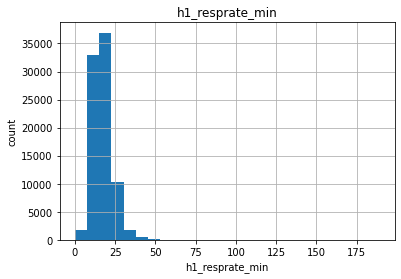

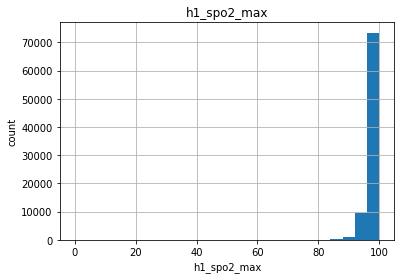

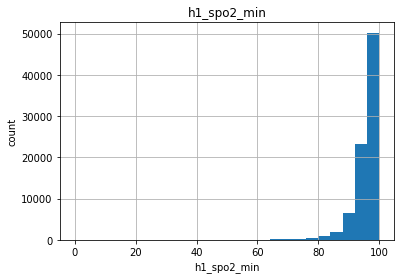

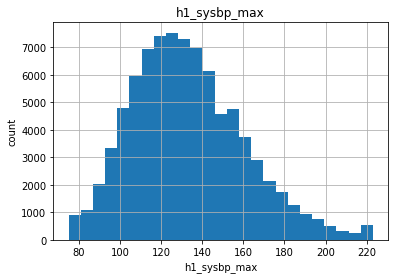

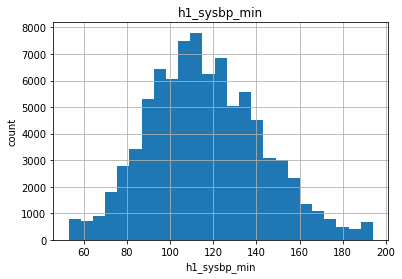

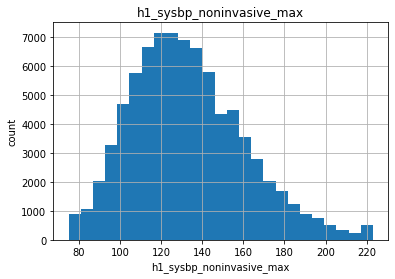

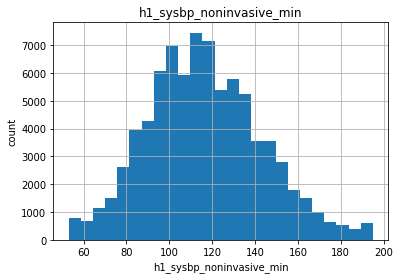

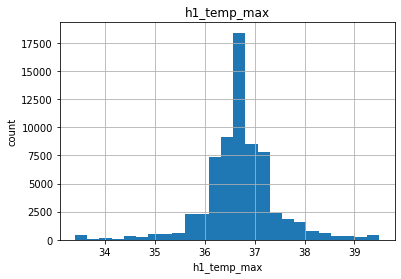

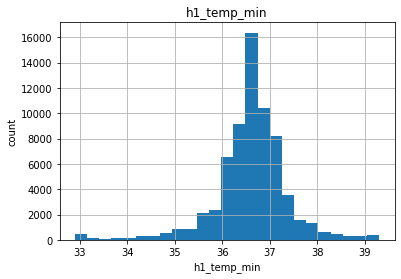

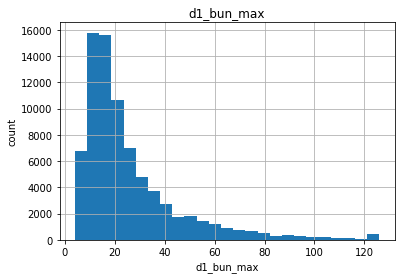

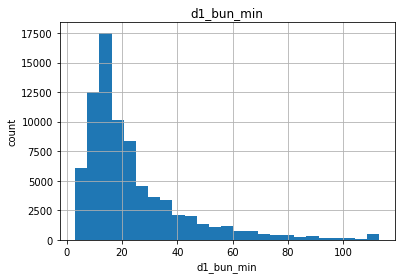

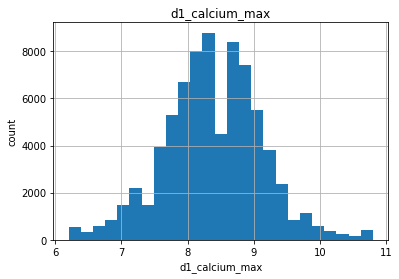

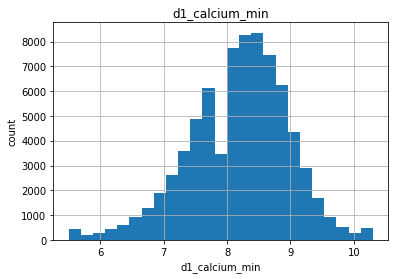

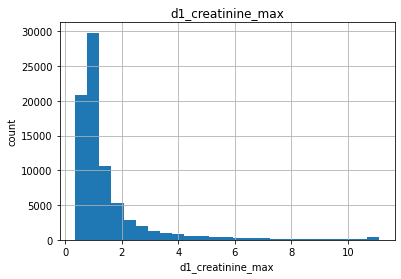

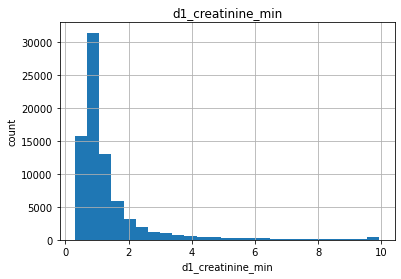

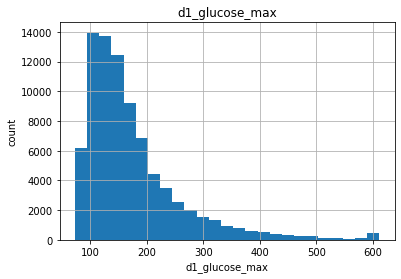

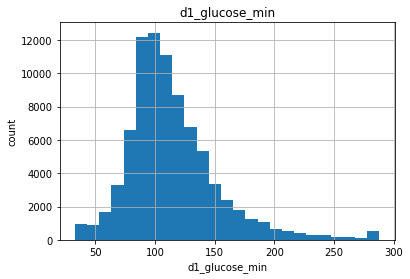

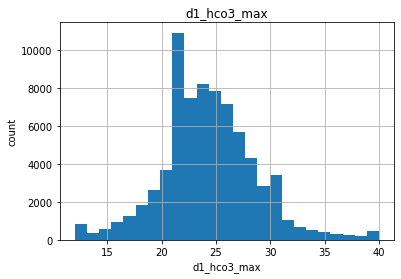

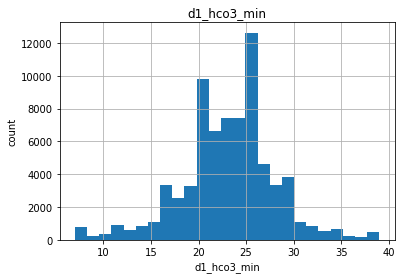

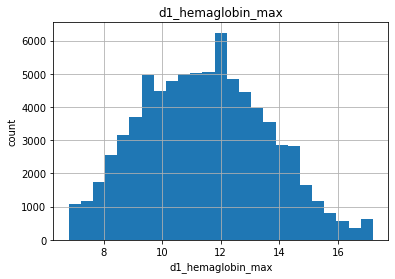

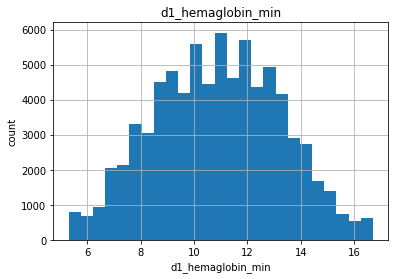

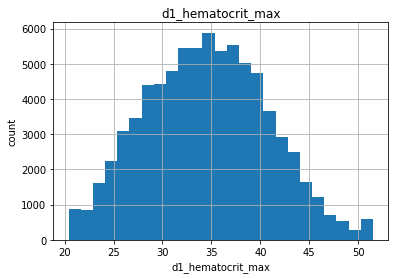

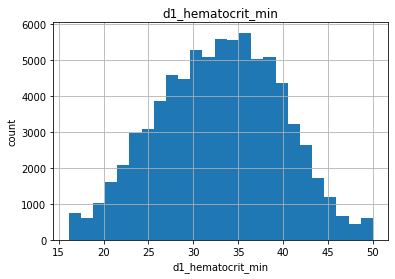

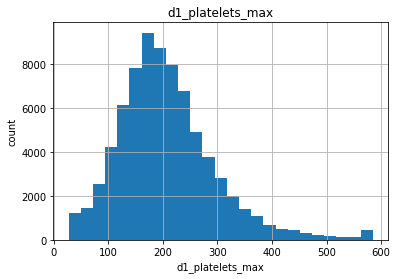

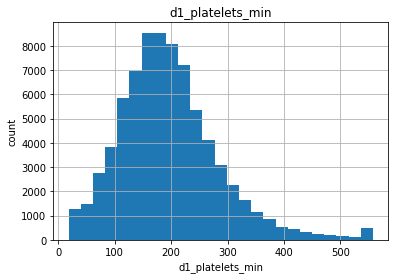

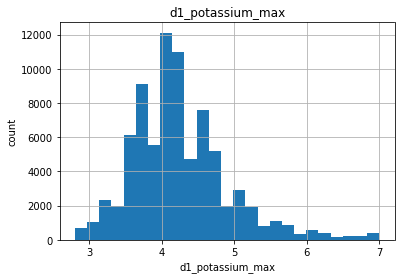

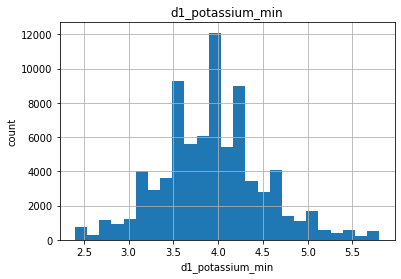

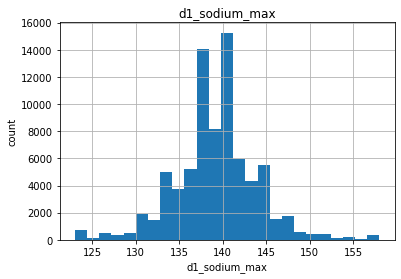

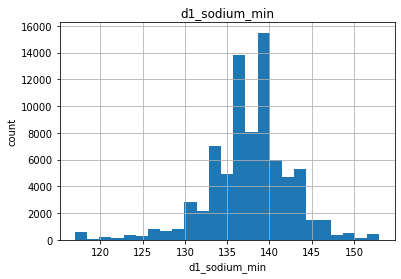

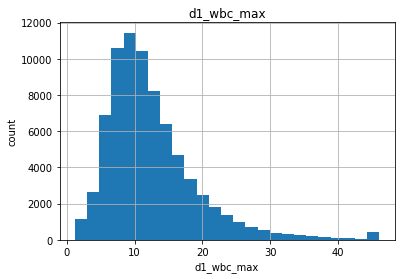

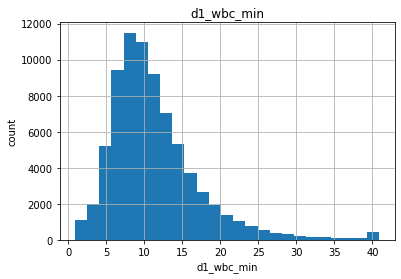

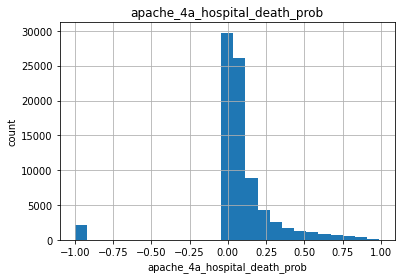

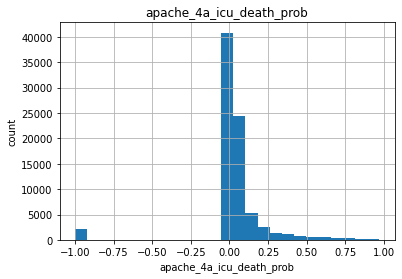

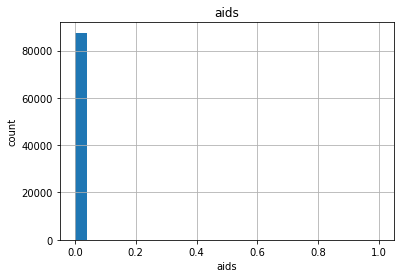

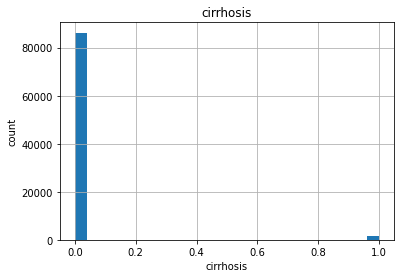

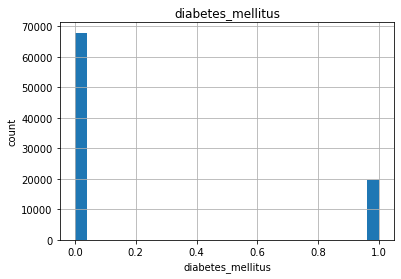

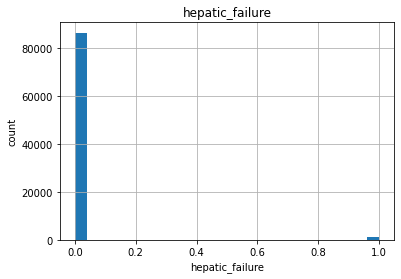

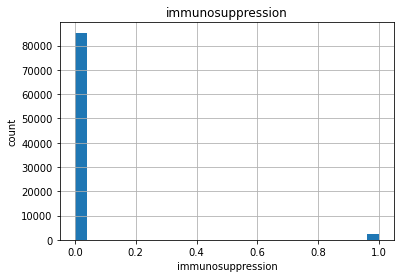

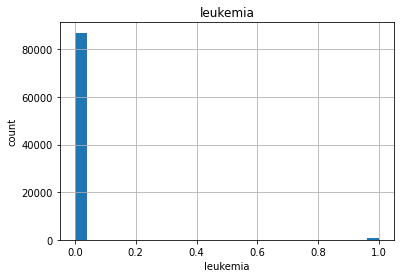

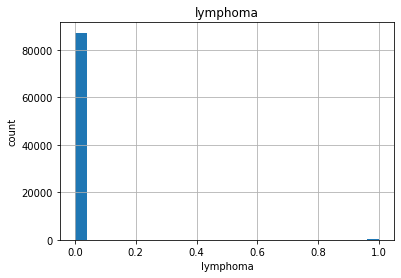

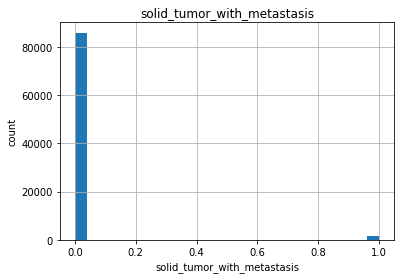

In [48]:
for col in numeric_cols:
    patientData[col].hist(bins=25)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(col)
    plt.show()

**From Above graphs**

* Columns with single constant value can be removed as they show no impact. As even diseases like AIDS, Cirhosis has constant values, they are diseases which may contributing to person's condition and his health diseases so let us keep the diseases as it is.

## PreProcessing:
    
    Encoding, Cleaning, Modifying, replacing values & making dataset ready for model training.

In [49]:
categoric_cols

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

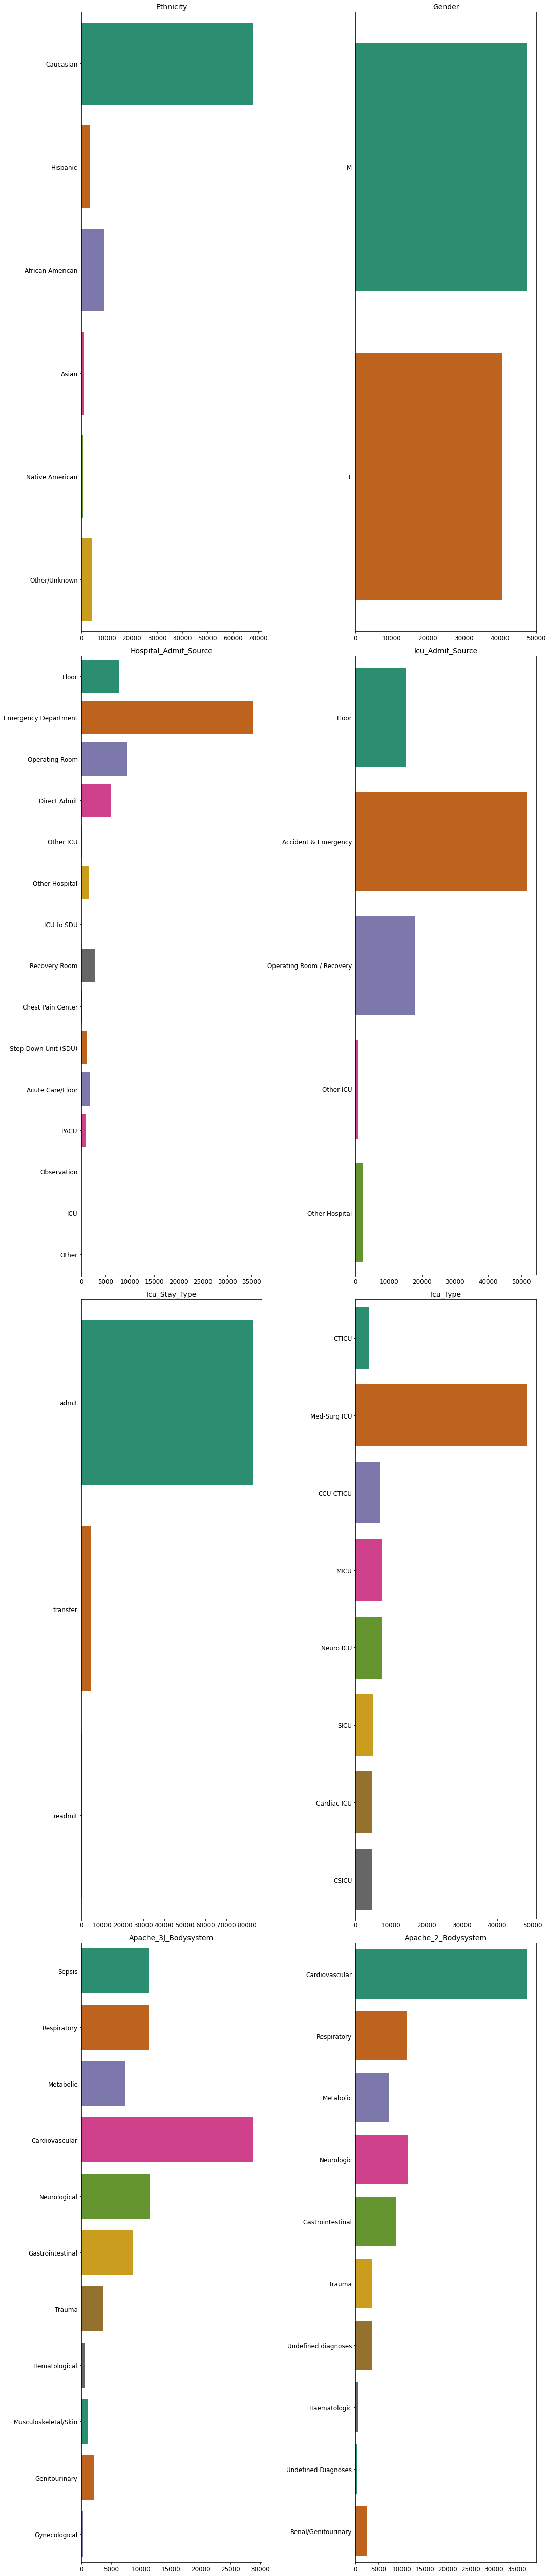

In [50]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in categoric_cols:
    if plotnumber <= len(categoric_cols):
        ax1 = plt.subplot(4,2,plotnumber)
        sns.countplot(data=patientData, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

#### observations:

* More of cardio vascular, people admitted in emergency rooms are been with higher probabilities with death.

In [51]:
# Categoric cols can be encoded

from sklearn.preprocessing import LabelEncoder

encoded_data = deepcopy(patientData)
encoded_data1 = deepcopy(patientData)
for col in categoric_cols:
    patientData[col] = LabelEncoder().fit_transform(patientData[col])

In [52]:
## Dealing with missing values
# will perform imputations.
# Let us perform median Imputation at first stage.
# https://towardsdatascience.com/imputing-numerical-data-top-5-techniques-every-data-scientist-must-know-587c0f51552a
encoded_data = deepcopy(patientData)
encoded_data1 = deepcopy(patientData)
encoded_data2 = deepcopy(patientData)
encoded_data3 = deepcopy(patientData)
encoded_data4 = deepcopy(patientData)
print(encoded_data.shape)

(88284, 107)


In [53]:
# Total null values
encoded_data.isnull().sum().sum()

525851

In [54]:
# As from above histograms, many features have skewed values.
# so lets impute the missing values with median.

def medianImpute(data,col,medianValue):
    data[col].fillna(medianValue,inplace=True)
    return data

In [55]:
for col in encoded_data.columns:
    cols = col 
    medianValue = encoded_data[col].median()
    medianImpute(encoded_data,cols,medianValue)
print(encoded_data.isnull().sum().sum())


0


* we can observe, there are no null values after imputation.

In [56]:
## Alternate way of imputing 
#---------------------------#
# from sklearn.preprocessing import Imputer
  
# imputer = Imputer(missing_values = "NaN",
#                   strategy = "median", axis = 0)
                    
# # Fitting the data, function learns the stats
# imputer = imputer.fit(data)
  
# data = imputer.fit_transform(data)

**C.BaseLine Modelling**

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

X = encoded_data.drop('hospital_death',axis=1)
y = encoded_data['hospital_death']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)


In [58]:
print("Shape of training set :",X_train.shape,y_train.shape)
print("Shape of testing set: ",X_test.shape,y_test.shape)

Shape of training set : (66213, 106) (66213,)
Shape of testing set:  (22071, 106) (22071,)


**Model Building**

A.***Logistic Regression***

In [59]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)


* Understanding of AUC:

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

* Metric to choose: 

https://medium.com/analytics-vidhya/how-to-select-performance-metrics-for-classification-models-c847fe6b1ea3

* RFC : 

https://towardsdatascience.com/understanding-random-forest-58381e0602d2

In [60]:
print("Accuracy of model is: ",accuracy_score(y_test, lr_pred))

Accuracy of model is:  0.9199855013365955


In [61]:
## AUC - Area Under Curve.
fpr,tpr,thresholds = metrics.roc_curve(y_test,lr_pred)
print("AUC for the model is: ",metrics.auc(fpr,tpr))

AUC for the model is:  0.5874195501834998


B.***Random Forest***

In [62]:
rf = RandomForestClassifier(n_estimators=200)

In [63]:
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print("Accuracy for random forest: ",accuracy_score(y_test, rf_pred))
fpr,tpr,thresholds = metrics.roc_curve(y_test,rf_pred)
print("AUC for the rf model is: ",metrics.auc(fpr,tpr))

Accuracy for random forest:  0.9290471659643876
AUC for the rf model is:  0.6335624408967924


In [64]:
rf.feature_importances_

array([0.01048787, 0.01178221, 0.00151374, 0.00265695, 0.00129619,
       0.00923911, 0.00416872, 0.0035023 , 0.00089003, 0.00428762,
       0.01260168, 0.01131917, 0.00889117, 0.01516869, 0.00090958,
       0.00073681, 0.00971785, 0.00956274, 0.01073618, 0.01310714,
       0.00078875, 0.00818533, 0.01003285, 0.0112479 , 0.00882876,
       0.00331213, 0.0101958 , 0.00885265, 0.00809569, 0.01243828,
       0.01068548, 0.00980015, 0.00848099, 0.00925837, 0.00831726,
       0.01000311, 0.01188165, 0.0185547 , 0.00866701, 0.01226411,
       0.00878991, 0.01200974, 0.00976349, 0.01059876, 0.00486637,
       0.0204013 , 0.0097994 , 0.01735786, 0.00987433, 0.01762865,
       0.01387586, 0.01438371, 0.0079393 , 0.00804049, 0.00760077,
       0.00791398, 0.00920062, 0.00929241, 0.00754679, 0.00740031,
       0.00743106, 0.00767094, 0.00897416, 0.00993888, 0.00586779,
       0.00812999, 0.00829058, 0.00906619, 0.0082473 , 0.00883503,
       0.00894764, 0.00942484, 0.01135873, 0.01142942, 0.00858

In [65]:
rta_impFeatures = pd.DataFrame()
rta_impFeatures['Features'] = X_train.columns
rta_impFeatures['Importance'] = rf.feature_importances_
rta_impFeatures.sort_values("Importance",ascending=False)

Features  Importance
94   apache_4a_hospital_death_prob    0.056342
95        apache_4a_icu_death_prob    0.056042
45                     d1_spo2_min    0.020401
37                d1_heartrate_min    0.018555
49        d1_sysbp_noninvasive_min    0.017629
47                    d1_sysbp_min    0.017358
13             apache_3j_diagnosis    0.015169
51                     d1_temp_min    0.014384
50                     d1_temp_max    0.013876
87                d1_platelets_min    0.013201
19                gcs_motor_apache    0.013107
81                     d1_hco3_min    0.012761
10                pre_icu_los_days    0.012602
29                     temp_apache    0.012438
86                d1_platelets_max    0.012383
39                      d1_mbp_min    0.012264
41          d1_mbp_noninvasive_min    0.012010
79                  d1_glucose_min    0.011882
36                d1_heartrate_max    0.011882
1                              bmi    0.011782
80                     d1_hco3_max    0.011623
76               d1_creatinine_max    0.011517
73                      d1_bun_min    0.011429
72                      d1_bun_max    0.011359
11                          weight    0.011319
23               heart_rate_apache    0.011248
93                      d1_wbc_min    0.010831
92                      d1_wbc_max    0.010790
18                 gcs_eyes_apache    0.010736
30               ventilated_apache    0.010685
43                 d1_resprate_min    0.010599
0                              age    0.010488
26                      map_apache    0.010196
77               d1_creatinine_min    0.010049
22                  glucose_apache    0.010033
35       d1_diasbp_noninvasive_min    0.010003
63                 h1_resprate_min    0.009939
48        d1_sysbp_noninvasive_max    0.009874
31                      wbc_apache    0.009800
46                    d1_sysbp_max    0.009799
42                 d1_resprate_max    0.009763
78                  d1_glucose_max    0.009758
16                      bun_apache    0.009718
17               creatinine_apache    0.009563
90                   d1_sodium_max    0.009487
71                     h1_temp_min    0.009425
57                h1_heartrate_min    0.009292
33                   d1_diasbp_min    0.009258
5                           height    0.009239
56                h1_heartrate_max    0.009201
89                d1_potassium_min    0.009069
67                    h1_sysbp_min    0.009066
75                  d1_calcium_min    0.009002
84               d1_hematocrit_max    0.008989
62                 h1_resprate_max    0.008974
70                     h1_temp_max    0.008948
85               d1_hematocrit_min    0.008946
12              apache_2_diagnosis    0.008891
27                 resprate_apache    0.008853
69        h1_sysbp_noninvasive_min    0.008835
24               hematocrit_apache    0.008829
40          d1_mbp_noninvasive_max    0.008790
38                      d1_mbp_max    0.008667
74                  d1_calcium_max    0.008585
32                   d1_diasbp_max    0.008481
88                d1_potassium_max    0.008474
82               d1_hemaglobin_max    0.008431
34       d1_diasbp_noninvasive_max    0.008317
83               d1_hemaglobin_min    0.008306
66                    h1_sysbp_max    0.008291
68        h1_sysbp_noninvasive_max    0.008247
21               gcs_verbal_apache    0.008185
65                     h1_spo2_min    0.008130
28                   sodium_apache    0.008096
91                   d1_sodium_min    0.008090
53                   h1_diasbp_min    0.008040
52                   h1_diasbp_max    0.007939
55       h1_diasbp_noninvasive_min    0.007914
61          h1_mbp_noninvasive_min    0.007671
54       h1_diasbp_noninvasive_max    0.007601
58                      h1_mbp_max    0.007547
60          h1_mbp_noninvasive_max    0.007431
59                      h1_mbp_min    0.007400
64                     h1_spo2_max    0.005868
104           apache_3j_bodysys

In [66]:
# selecting features

usefulFeatures = list(rta_impFeatures.sort_values("Importance", ascending=False)['Features'].head(120).values)
usefulFeatures

['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'd1_spo2_min',
 'd1_heartrate_min',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_min',
 'apache_3j_diagnosis',
 'd1_temp_min',
 'd1_temp_max',
 'd1_platelets_min',
 'gcs_motor_apache',
 'd1_hco3_min',
 'pre_icu_los_days',
 'temp_apache',
 'd1_platelets_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_glucose_min',
 'd1_heartrate_max',
 'bmi',
 'd1_hco3_max',
 'd1_creatinine_max',
 'd1_bun_min',
 'd1_bun_max',
 'weight',
 'heart_rate_apache',
 'd1_wbc_min',
 'd1_wbc_max',
 'gcs_eyes_apache',
 'ventilated_apache',
 'd1_resprate_min',
 'age',
 'map_apache',
 'd1_creatinine_min',
 'glucose_apache',
 'd1_diasbp_noninvasive_min',
 'h1_resprate_min',
 'd1_sysbp_noninvasive_max',
 'wbc_apache',
 'd1_sysbp_max',
 'd1_resprate_max',
 'd1_glucose_max',
 'bun_apache',
 'creatinine_apache',
 'd1_sodium_max',
 'h1_temp_min',
 'h1_heartrate_min',
 'd1_diasbp_min',
 'height',
 'h1_heartrate_max',
 'd1_potassium_min',
 'h1_sysbp_min',
 'd1_

In [67]:
impFeatures = X[usefulFeatures]
impFeatures.shape

(88284, 106)

In [68]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(impFeatures,y,test_size=0.25,random_state=42)

In [69]:
rf1 = RandomForestClassifier()
rf1.fit(X_train1,y_train1)
rf1_pred = rf1.predict(X_test1)

In [70]:
##### print("AUC: ")
print("Accuracy of important features model is: ",accuracy_score(y_test, rf1_pred))
fpr1,tpr1,thresholds1 = metrics.roc_curve(y_test1,rf1_pred)
print("AUC for the rf model is: ",metrics.auc(fpr1,tpr1))

Accuracy of important features model is:  0.9276426079470799
AUC for the rf model is:  0.6279072459464466


* Same results as with all features

C.***XgBoost***

<AxesSubplot:>

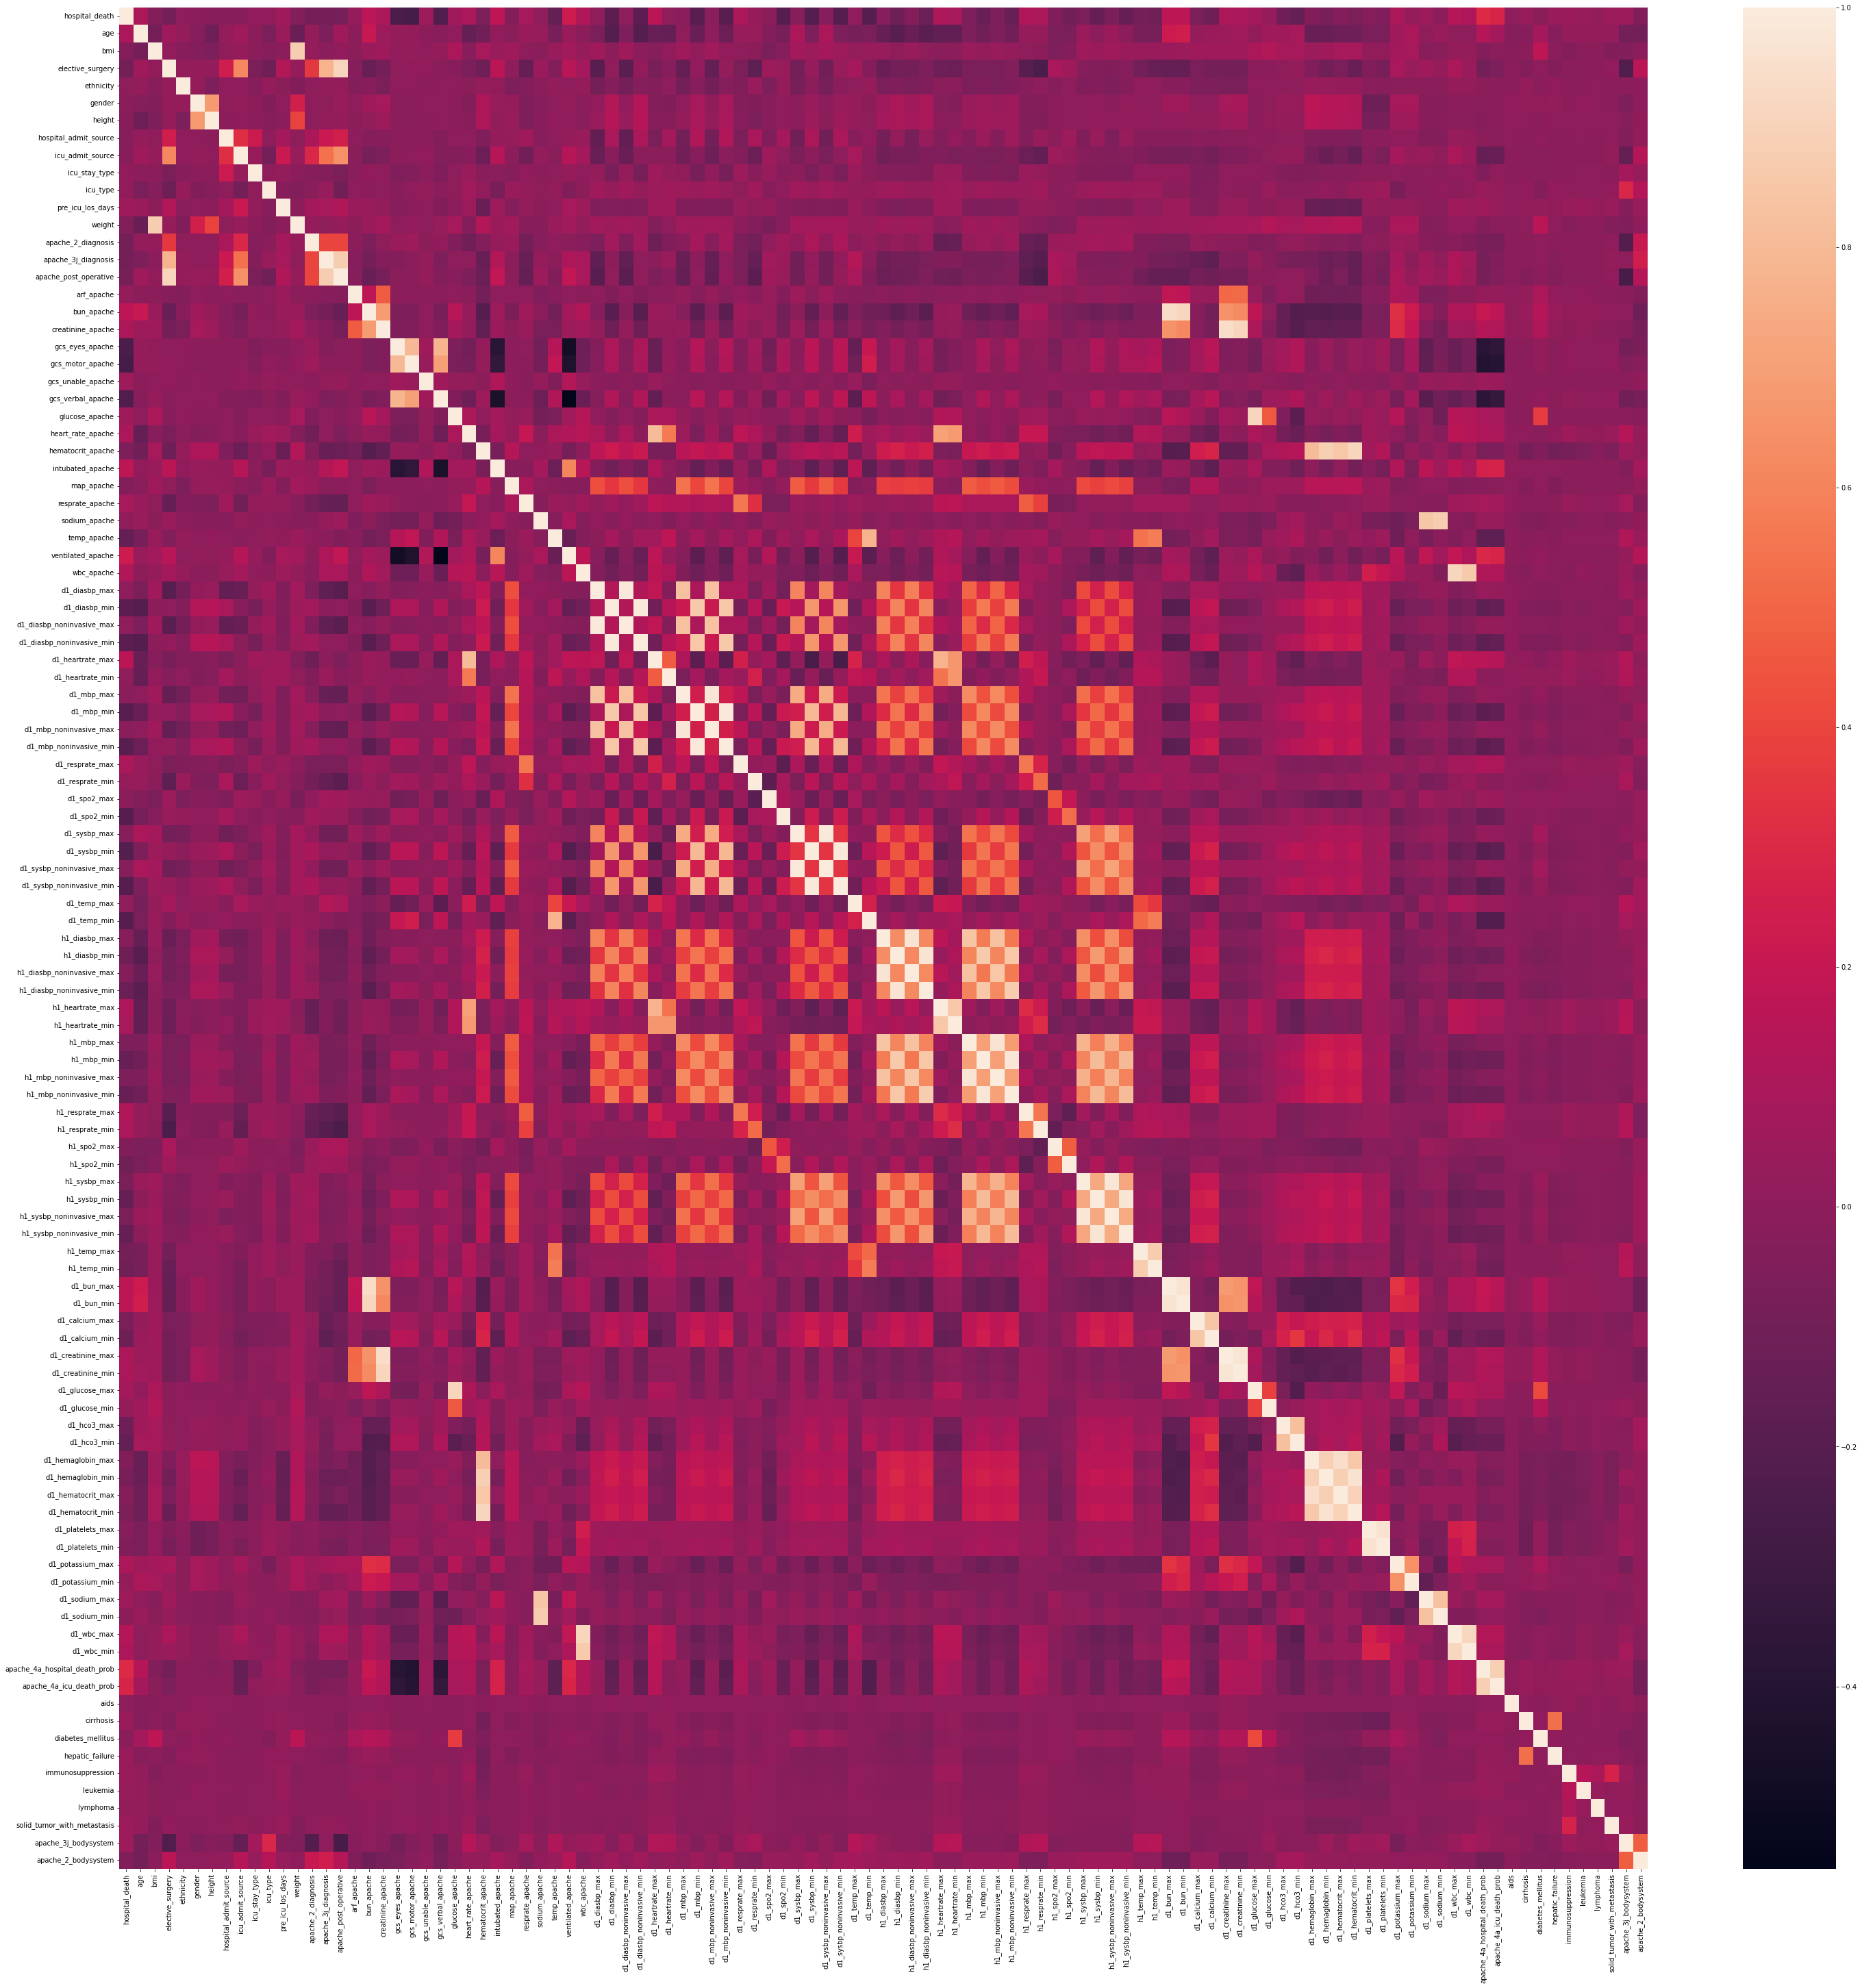

In [116]:
plt.figure(figsize=(50,50))
sns.heatmap(encoded_data.corr())

In [117]:
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)

# Metrics

print("Accuracy for XGB is: ",accuracy_score(y_test,xgb_pred))
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_test,xgb_pred)
print("AUC for the XGB model is: ",metrics.auc(fpr2,tpr2))


Accuracy for XGB is:  0.9289112409949708


AttributeError: 'list' object has no attribute 'roc_curve'

**Metrics results increases in XGBmodel as compared to both randomForest & Logistic Regression**

In [118]:
xgb.feature_importances_

array([0.00802963, 0.00744408, 0.02044354, 0.00544969, 0.00530188,
       0.00607257, 0.00617306, 0.01099326, 0.00802015, 0.00530588,
       0.00682324, 0.00596358, 0.00639081, 0.00878373, 0.        ,
       0.00761296, 0.00647974, 0.00899599, 0.00818682, 0.0115683 ,
       0.00855674, 0.00628385, 0.00681256, 0.00746676, 0.00652695,
       0.02506174, 0.00642697, 0.00776004, 0.00627001, 0.00548761,
       0.02317865, 0.00875162, 0.00606836, 0.00556943, 0.00565441,
       0.00929976, 0.00708642, 0.01209177, 0.00718869, 0.0101796 ,
       0.00794672, 0.00915507, 0.00723212, 0.00994564, 0.01280019,
       0.01610127, 0.00575314, 0.01288221, 0.00866288, 0.01772069,
       0.00916826, 0.009767  , 0.00485045, 0.00418159, 0.00583892,
       0.00428748, 0.00555611, 0.00586993, 0.00562769, 0.0065135 ,
       0.00679378, 0.00712822, 0.00561505, 0.00604715, 0.00530796,
       0.00430555, 0.00649508, 0.006396  , 0.0059721 , 0.0052682 ,
       0.00753803, 0.00638581, 0.01537329, 0.01099016, 0.00664

In [119]:
xgb_impFeatures = pd.DataFrame()
xgb_impFeatures['Features'] = X_train.columns
xgb_impFeatures['Importance'] = xgb.feature_importances_
xgb_impFeatures.sort_values("Importance",ascending=False)
usefulFeatures1 = list(xgb_impFeatures.sort_values("Importance", ascending=False)['Features'].head(120).values)
impFeatures1 = X[usefulFeatures1]
impFeatures1.shape

(88284, 106)

In [120]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(impFeatures1,y,test_size=0.25,random_state=42)

In [121]:
# Xgb important
xgb_imp = XGBClassifier()
xgb_imp.fit(X_train2,y_train2)
xgbImp_pred = xgb_imp.predict(X_test2)

# Metrics

print("Accuracy for XGB is: ",accuracy_score(y_test2,xgbImp_pred))
fpr3,tpr3,thresholds3 = metrics.roc_curve(y_test2,xgbImp_pred)
print("AUC for the XGB model is: ",metrics.auc(fpr3,tpr3))


Accuracy for XGB is:  0.9282316161478864


AttributeError: 'list' object has no attribute 'roc_curve'

In [122]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_hat) , 3)
    fpr, tpr, t = roc_curve(y_test, y_hat)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                          specs=[ 
#                               [{'colspan': 2}, None],
                                 [{}, {}],
                                 [{}, {}],
                                 
#                                  [{'colspan': 2}, None]
                                ],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)
model_performance(xgb_imp,y_test, xgbImp_pred)

## HyperParameter Tuning

* Lets use Xgb model.

In [123]:
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

fit_params_of_xgb = {
    "early_stopping_rounds":100, 
    "eval_metric" : 'auc', 
    "eval_set" : [(X_test, y_test)],
    'verbose': 100,
}


# A parameter grid for XGBoost
params = {
    'booster': ["gbtree"],
    'learning_rate': [0.1],
    'n_estimators': range(100, 500, 100),
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'max_depth': [5],
    "scale_pos_weight": [1]
}

xgb_estimator = XGBClassifier(
    objective='binary:logistic',
    # silent=True,
)

gsearch = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=gkf
)

xgb_model = gsearch.fit(X=X_train, y=y_train, **fit_params_of_xgb)
(gsearch.best_params_, gsearch.best_score_)

[0]	validation_0-auc:0.84758
[0]	validation_0-auc:0.84303
[99]	validation_0-auc:0.89559
[99]	validation_0-auc:0.89604
[0]	validation_0-auc:0.84803
[0]	validation_0-auc:0.84758
[99]	validation_0-auc:0.89822
[100]	validation_0-auc:0.89557
[0]	validation_0-auc:0.84303
[199]	validation_0-auc:0.89741
[100]	validation_0-auc:0.89597
[0]	validation_0-auc:0.84803
[199]	validation_0-auc:0.89735
[100]	validation_0-auc:0.89826
[0]	validation_0-auc:0.84758
[199]	validation_0-auc:0.90064
[0]	validation_0-auc:0.84303
[100]	validation_0-auc:0.89557
[200]	validation_0-auc:0.89740
[100]	validation_0-auc:0.89597
[284]	validation_0-auc:0.89692
[0]	validation_0-auc:0.84803
[200]	validation_0-auc:0.89722
[243]	validation_0-auc:0.89727
[0]	validation_0-auc:0.84758
[100]	validation_0-auc:0.89826
[100]	validation_0-auc:0.89557
[200]	validation_0-auc:0.90060
[200]	validation_0-auc:0.89740
[299]	validation_0-auc:0.89969
[0]	validation_0-auc:0.84303
[284]	validation_0-auc:0.89692
[0]	validation_0-auc:0.84803
[100

({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 200,
  'scale_pos_weight': 1,
  'subsample': 0.8},
 0.8915516753188096)

## Model Evaluation

In [124]:
xgb_tuned = XGBClassifier(n_estimators=4000,
    objective='binary:logistic',
    booster="gbtree",
    learning_rate=0.01,
    scale_pos_weight=1,
    max_depth=4,
    min_child_weight=6,
    gamma=0,
    subsample=0.4,
    colsample_bytree=0.8,
    reg_alpha=0.08,
    n_jobs=-1)

xgb_tuned.fit(X_train, y_train)
y__hat = xgb_tuned.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/p

In [125]:

print("Accuracy for XGB is: ",accuracy_score(y_test,y__hat))
fpr4,tpr4,thresholds4 = metrics.roc_curve(y_test,y__hat)
print("AUC for the XGB model is: ",metrics.auc(fpr4,tpr4))


Accuracy for XGB is:  0.9325359068460877


AttributeError: 'list' object has no attribute 'roc_curve'

In [126]:
model_performance(xgb_tuned,y_test, y__hat)

### Saving XGB model

In [127]:
import joblib

with open('./xgb_tuned_final.pkl.compressed', 'wb') as m:
    joblib.dump(xgb_tuned, m, compress=3)

# Using Neural Network

In [128]:
import os
import PIL
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [129]:

NX = encoded_data.drop('hospital_death',axis=1)
Ny = encoded_data['hospital_death']
NX_train,NX_test,Ny_train,Ny_test = train_test_split(NX,Ny,test_size=0.3,shuffle=True,random_state=8)


In [130]:
### Standardization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
NX_scaled = scaler.fit_transform(NX_train)
NXtest_Scaled = scaler.fit_transform(NX_test)

In [131]:
NX_df = pd.DataFrame(NX_scaled,columns=NX_train.columns)
NX_testdf = pd.DataFrame(NXtest_Scaled,columns=NX_test.columns)

In [132]:
# Building model
model = Sequential()
model.add(Dense(64,input_shape=(NX_df.shape[-1],),activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()
          

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                6848      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________


In [133]:
metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')
]


### Compiling the model
### choosing an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(0.01),
              loss='binary_crossentropy',
              metrics=metrics)
epochs = 20
batch_size = 32
history = model.fit(NX_df.values,Ny_train, validation_data = (NX_testdf, Ny_test), epochs=epochs, batch_size=batch_size)

Epoch 1/20
1932/1932 [==============================] - 12s 6ms/step - loss: 0.2231 - precision: 0.6169 - recall: 0.1638 - auc_1: 0.8380 - val_loss: 0.2125 - val_precision: 0.7965 - val_recall: 0.1200 - val_auc_1: 0.8681
Epoch 2/20
1932/1932 [==============================] - 10s 5ms/step - loss: 0.2118 - precision: 0.6432 - recall: 0.2200 - auc_1: 0.8594 - val_loss: 0.2063 - val_precision: 0.6846 - val_recall: 0.2453 - val_auc_1: 0.8714
Epoch 3/20
1932/1932 [==============================] - 10s 5ms/step - loss: 0.2092 - precision: 0.6465 - recall: 0.2395 - auc_1: 0.8635 - val_loss: 0.2048 - val_precision: 0.6489 - val_recall: 0.2834 - val_auc_1: 0.8736
Epoch 4/20
1932/1932 [==============================] - 11s 6ms/step - loss: 0.2089 - precision: 0.6553 - recall: 0.2334 - auc_1: 0.8640 - val_loss: 0.2111 - val_precision: 0.6008 - val_recall: 0.3329 - val_auc_1: 0.8744
Epoch 5/20
1932/1932 [==============================] - 10s 5ms/step - loss: 0.2072 - precision: 0.6743 - recall: 0.

In [136]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC Score')
plt.plot(epochs_range, val_acc, label='Validation AUC Score')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

KeyError: 'auc'

In [137]:
model.save("dl1.pkl")

# PyTorch Version

In [138]:
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset,DataLoader

from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import confusion_matrix, classification_report

In [139]:

X_torch = encoded_data.drop('hospital_death',axis=1)
y_torch = encoded_data['hospital_death']


In [140]:
sc = StandardScaler()
XX = sc.fit_transform(X_torch)

In [141]:
Xt_train,Xt_test,yt_train,yt_test = train_test_split(XX,y_torch,test_size=0.34,random_state=42)

In [142]:
epochs = 60
batch_size = 32 
learning_rate = 0.001 

In [143]:
 class PatientTrain(Dataset):
        
        def __init__(self,X_data,y_data):
            self.X_data = X_data
            self.y_data = y_data 
        
        def __getitem__(self,index):
            return self.X_data[index],self.y_data[index]
        def __len__(self):
            return len(self.X_data)
        
class PatientTest(Dataset):
    
    def __init__(self,X_data):
        self.X_data = X_data 
    def __getitem__(self,index):
        return self.X_data[index]
    def __len__(self):
        return len(self.X_data)
    

In [144]:
trainData = PatientTrain(torch.FloatTensor(Xt_train),torch.FloatTensor(yt_train))
testData = PatientTest(torch.FloatTensor(Xt_test))

In [145]:
trainLoader = DataLoader(dataset = trainData,batch_size=32,shuffle=True)
testLoader = DataLoader(dataset = testData,batch_size=32)

In [146]:
Xt_train.shape,yt_train.shape,Xt_test.shape,yt_test.shape

((58267, 106), (58267,), (30017, 106), (30017,))

In [147]:
# Model 

class PatientNet(nn.Module):
    def __init__(self):
        super(PatientNet,self).__init__()
        self.layer1 = nn.Linear(106,64)
        self.layer2 = nn.Linear(64,64)
        self.layerOut = nn.Linear(64,1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self,inputs):
        x = self.relu(self.layer1(inputs))
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layerOut(x)
        
        return x 

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [149]:
models = PatientNet()
models.to(device)
print(models)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(models.parameters(),lr=learning_rate)


PatientNet(
  (layer1): Linear(in_features=106, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layerOut): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [150]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [151]:
losss = []
accs = []
epoch_losss = []
epoch_accs = []
for epoch in range(1,epochs+1):
    epoch_loss = 0 
    epoch_acc = 0 
    for X_batch,y_batch in trainLoader:
        X_batch,y_batch = X_batch.to(device),y_batch.to(device)
        y_pred = models(X_batch)
        
        loss = criterion(y_pred,y_batch.unsqueeze(1))
        acc = binary_acc(y_pred,y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        losss.append(epoch_loss)
        accs.append(epoch_acc)
    epoch_losss.append(epoch_loss/len(trainLoader))
    epoch_accs.append(epoch_acc/len(trainLoader))
    
    print(f'Epoch {epoch}: | Loss: {epoch_loss/len(trainLoader):.5f} | Acc: {epoch_acc/len(trainLoader):.3f}')

    

Epoch 1: | Loss: 0.32681 | Acc: 91.574
Epoch 2: | Loss: 0.33469 | Acc: 91.794
Epoch 3: | Loss: 0.31539 | Acc: 91.799
Epoch 4: | Loss: 0.31357 | Acc: 91.799
Epoch 5: | Loss: 0.31023 | Acc: 91.806
Epoch 6: | Loss: 0.30373 | Acc: 91.790
Epoch 7: | Loss: 0.30421 | Acc: 91.798
Epoch 8: | Loss: 0.30930 | Acc: 91.785
Epoch 9: | Loss: 0.29966 | Acc: 91.791
Epoch 10: | Loss: 0.30295 | Acc: 91.792
Epoch 11: | Loss: 0.29808 | Acc: 91.798
Epoch 12: | Loss: 0.30133 | Acc: 91.797
Epoch 13: | Loss: 0.29659 | Acc: 91.805
Epoch 14: | Loss: 0.29760 | Acc: 91.794
Epoch 15: | Loss: 0.29565 | Acc: 91.792
Epoch 16: | Loss: 0.29767 | Acc: 91.790
Epoch 17: | Loss: 0.29528 | Acc: 91.804
Epoch 18: | Loss: 0.29388 | Acc: 91.801
Epoch 19: | Loss: 0.29616 | Acc: 91.797
Epoch 20: | Loss: 0.29444 | Acc: 91.791
Epoch 21: | Loss: 0.29350 | Acc: 91.795
Epoch 22: | Loss: 0.29274 | Acc: 91.795
Epoch 23: | Loss: 0.29341 | Acc: 91.794
Epoch 24: | Loss: 0.29213 | Acc: 91.798
Epoch 25: | Loss: 0.29267 | Acc: 91.795
Epoch 26:

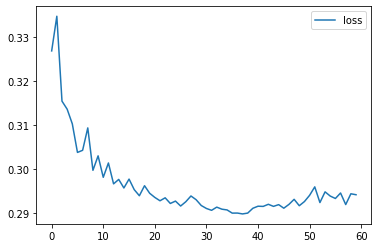

In [152]:
#plot loss and accuracy
plt.plot(epoch_losss, label='loss')
plt.legend()
plt.show()

* We can observe, at epoch in range(0,5), loss is high as 0.32, and from then it decreased at every stage of epoch and finally stopped at 0.29 for epoch 60.
* There is a bit of ups and downs for the loss, which shouldn't be case of modelling. Let us try another epoch range.

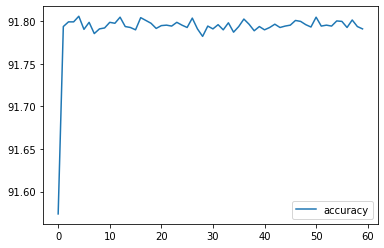

In [153]:
plt.plot(epoch_accs, label='accuracy')
plt.legend()
plt.show()


* Accuracy didnt increase much, from first epoch to 60th epoch, but there is a drastic changes being happened in between the epoch ranges.

In [154]:
y_pred_list = []
models.eval()
with torch.no_grad():
    for X_batch in testLoader:
        X_batch = X_batch.to(device)
        y_test_pred = models(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

* As it is a binary classification, we have used sigmoid as a function

** Saving the models.

Reference: 

https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch

In [155]:
# 1. Save the model to use it yourself for inference
torch.save(models.state_dict(), 'torch_modelv1.pth')

#Later to restore:
models.load_state_dict(torch.load('torch_modelv1.pth'))
models.eval()

PatientNet(
  (layer1): Linear(in_features=106, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layerOut): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [156]:

# 2: Save model to resume training later: If you need to keep training the model that you are about to save, you need to save more than just the model. You also need to save the state of the optimizer, epochs, score, etc. You would do it like this:

state = {
    'epoch': epoch,
    'state_dict': models.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, 'torch_modelv1_usage.pth')


In [157]:
# To restore:

models.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
print(models.state_dict)

<bound method Module.state_dict of PatientNet(
  (layer1): Linear(in_features=106, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layerOut): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)>


In [158]:
print(optimizer.state_dict)

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)>


In [159]:
# 3.  Model to be used by someone else with no access to your code: 
torch.save(models, 'torch_modelv1_noUsage.pth')

# Then later:
modelling = torch.load('torch_modelv1_noUsage.pth')


In [160]:
print("Done!")

Done!


In [161]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/xgb_tuned_final.pkl.compressed (deflated 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/torch_modelv1_usage.pth (deflated 12%)
  adding: kaggle/working/torch_modelv1_noUsage.pth (deflated 23%)
  adding: kaggle/working/torch_modelv1.pth (deflated 23%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/dl1.pkl/ (stored 0%)
  adding: kaggle/working/dl1.pkl/variables/ (stored 0%)
  adding: kaggle/working/dl1.pkl/variables/variables.data-00000-of-00001 (deflated 38%)
  adding: kaggle/working/dl1.pkl/variables/variables.index (deflated 66%)
  adding: kaggle/working/dl1.pkl/keras_metadata.pb (deflated 88%)
  adding: kaggle/working/dl1.pkl/saved_model.pb (deflated 88%)
  adding: kaggle/working/dl1.pkl/assets/ (stored 0%)
